# Predicting International Student Academic Success Using a Hybrid Machine Learning Model

## Complete Framework: LSTM + Random Forest + Meta-Learner Fusion

**Thesis Support**: This notebook implements a generalized, explainable hybrid prediction framework for international students in Latvian higher education.

**Components**:
1. **LSTM**: Temporal/weekly engagement patterns (32 weeks)
2. **Random Forest**: Static + aggregated features
3. **Hybrid Meta-Learner**: Fusion of LSTM and RF probabilities

**Author**: Master's Thesis Research
**Date**: November 2024

## 1. Import Required Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')
print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.3
Pandas version: 2.3.2


## 2. Load Datasets

In [2]:
# Define file paths
PATHS = {
    'latvia_static': './uploads/international_students_static_latvia.csv',
    'latvia_temporal': './uploads/international_students_temporal_latvia.csv',
    'global_static': './uploads/global_static_students.csv',
    'global_temporal': './uploads/global_temporal_students_32w.csv'
}

# Load all datasets
print('Loading datasets...')
df_latvia_static = pd.read_csv(PATHS['latvia_static'])
df_latvia_temporal = pd.read_csv(PATHS['latvia_temporal'])
df_global_static = pd.read_csv(PATHS['global_static'])
df_global_temporal = pd.read_csv(PATHS['global_temporal'])

# Combine Latvia and Global datasets
df_static = pd.concat([df_latvia_static, df_global_static], ignore_index=True)
df_temporal = pd.concat([df_latvia_temporal, df_global_temporal], ignore_index=True)

print('\n📊 Combined Dataset Statistics:')
print(f'Total students (static): {len(df_static)}')
print(f'Total temporal records: {len(df_temporal)}')
print(f'Unique students in temporal: {df_temporal["student_id"].nunique()}')
print(f'\nInstitutions: {df_static["institution"].nunique()}')
print(f'Countries: {df_static["country_home"].nunique()}')
print(f'Subject fields: {df_static["subject_field"].nunique()}')

# Show Latvian institutions
latvian_institutions = df_static[df_static['country_host'] == 'Latvia']['institution'].unique()
print(f'\nLatvian institutions: {list(latvian_institutions)}')

Loading datasets...

📊 Combined Dataset Statistics:
Total students (static): 1780
Total temporal records: 62960
Unique students in temporal: 1780

Institutions: 10
Countries: 19
Subject fields: 7

Latvian institutions: ['Latvia_Uni_A', 'Latvia_College_C', 'Latvia_Uni_B', 'Tech_Institute_D', 'Business_School_E', 'Latvia_Test_Uni_G']


## 3. Data Preprocessing - Static Features

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define feature categories
categorical_features = [
    'institution', 'program_id', 'country_home', 'country_host',
    'subject_field', 'study_level', 'study_mode', 'gender',
    'marital_status', 'language_proficiency', 'support_program',
    'scholarship_status'
]

numerical_features = [
    'age', 'teaching_style_difference', 'cultural_distance',
    'work_hours_per_week', 'entry_gpa', 'gpa_sem1', 'gpa_sem2', 'gpa_prev',
    'credits_attempted_sem1', 'credits_earned_sem1', 'credits_attempted_sem2',
    'credits_earned_sem2', 'failed_courses_sem1', 'failed_courses_sem2',
    'attendance_rate', 'mean_weekly_engagement', 'std_weekly_engagement',
    'low_engagement_weeks', 'engagement_trend', 'avg_assignment_score',
    'avg_exam_score', 'late_submission_rate', 'missing_assignments_count'
]

binary_features = [
    'participates_in_buddy_program', 'participates_in_language_course',
    'works_while_studying'
]

# Identify actual data types in the dataframe
print('Identifying actual data types...')
actual_numerical = []
actual_categorical = []
actual_binary = []

for col in numerical_features:
    if col in df_static.columns:
        # Check if column is truly numerical
        try:
            # Try to convert to numeric
            pd.to_numeric(df_static[col], errors='raise')
            actual_numerical.append(col)
        except (ValueError, TypeError):
            # If conversion fails, it's categorical
            print(f"Warning: '{col}' contains non-numeric values, treating as categorical")
            unique_vals = df_static[col].dropna().unique()
            print(f"  Unique values in '{col}': {unique_vals[:10]}")  # Show first 10 unique values
            actual_categorical.append(col)

# Add originally defined categorical features
for col in categorical_features:
    if col in df_static.columns:
        actual_categorical.append(col)

# Check binary features
for col in binary_features:
    if col in df_static.columns:
        actual_binary.append(col)

# Remove duplicates
actual_categorical = list(set(actual_categorical))
actual_numerical = list(set(actual_numerical))
actual_binary = list(set(actual_binary))

print(f"\nActual numerical features: {len(actual_numerical)}")
print(f"Actual categorical features: {len(actual_categorical)}")
print(f"Actual binary features: {len(actual_binary)}")

# Handle missing values for NUMERICAL features
print('\nHandling missing values for numerical features...')
for col in actual_numerical:
    # Convert to numeric first, coercing errors to NaN
    df_static[col] = pd.to_numeric(df_static[col], errors='coerce')
    # Fill NaN with median
    median_val = df_static[col].median()
    df_static[col].fillna(median_val, inplace=True)
    print(f"  {col}: filled {df_static[col].isna().sum()} missing values with median {median_val:.3f}")

# Handle missing values for CATEGORICAL features
print('\nHandling missing values for categorical features...')
for col in actual_categorical:
    missing_count = df_static[col].isna().sum()
    df_static[col].fillna('Unknown', inplace=True)
    print(f"  {col}: filled {missing_count} missing values with 'Unknown'")

# Handle missing values for BINARY features
print('\nHandling missing values for binary features...')
for col in actual_binary:
    # For binary features, fill with mode (most common value) or 0
    if df_static[col].isna().sum() > 0:
        mode_val = df_static[col].mode()[0] if len(df_static[col].mode()) > 0 else 0
        missing_count = df_static[col].isna().sum()
        df_static[col].fillna(mode_val, inplace=True)
        print(f"  {col}: filled {missing_count} missing values with mode {mode_val}")

# Encode categorical variables
print('\nEncoding categorical features...')
label_encoders = {}
for col in actual_categorical:
    le = LabelEncoder()
    df_static[col + '_encoded'] = le.fit_transform(df_static[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: encoded {len(le.classes_)} unique categories")

# Scale numerical features
print('\nScaling numerical features...')
scaler = StandardScaler()
if len(actual_numerical) > 0:
    df_static[actual_numerical] = scaler.fit_transform(df_static[actual_numerical])
    print(f"  Scaled {len(actual_numerical)} numerical features")

# Select features for model
encoded_categorical = [col + '_encoded' for col in actual_categorical]
static_feature_cols = actual_numerical + actual_binary + encoded_categorical
static_feature_cols = [col for col in static_feature_cols if col in df_static.columns]

print(f'\n{"="*60}')
print(f'FEATURE PREPARATION SUMMARY')
print(f'{"="*60}')
print(f'Numerical features: {len(actual_numerical)}')
print(f'Categorical features (encoded): {len(encoded_categorical)}')
print(f'Binary features: {len(actual_binary)}')
print(f'Total static features prepared: {len(static_feature_cols)}')
print(f'{"="*60}')

# Verify no missing values remain
print(f'\nMissing values check:')
missing_in_features = df_static[static_feature_cols].isna().sum().sum()
print(f'  Total missing values in selected features: {missing_in_features}')

if missing_in_features > 0:
    print('\nColumns with missing values:')
    for col in static_feature_cols:
        missing = df_static[col].isna().sum()
        if missing > 0:
            print(f'  {col}: {missing} missing values')

Identifying actual data types...
  Unique values in 'teaching_style_difference': ['High' 'Low' 'Medium' 0.8158425631014783 0.3147906761577044
 0.8051659914501663 0.5486913021399775 0.1620885547843459
 0.5982809134038996 0.5258613950332681]

Actual numerical features: 22
Actual categorical features: 13
Actual binary features: 3

Handling missing values for numerical features...
  gpa_sem1: filled 0 missing values with median 6.620
  gpa_sem2: filled 0 missing values with median 6.645
  credits_earned_sem2: filled 0 missing values with median 25.000
  attendance_rate: filled 0 missing values with median 0.679
  late_submission_rate: filled 0 missing values with median 0.362
  failed_courses_sem1: filled 0 missing values with median 1.000
  low_engagement_weeks: filled 0 missing values with median 1.000
  failed_courses_sem2: filled 0 missing values with median 1.000
  avg_exam_score: filled 0 missing values with median 48.066
  missing_assignments_count: filled 0 missing values with medi

## 4. Create Temporal Sequences for LSTM

In [4]:
def create_temporal_sequences(df_temporal, df_static, sequence_length=32):
    """Create temporal sequences aligned with static data."""
    
    temporal_features = [
        'weekly_engagement', 'weekly_attendance',
        'weekly_assignments_submitted', 'weekly_quiz_attempts'
    ]
    
    sequences_dict = {}
    
    # Group by student and create sequences
    for student_id, group in df_temporal.groupby('student_id'):
        group = group.sort_values('week_index')
        
        # Get feature values
        feature_data = group[temporal_features].values
        
        # Pad or truncate to sequence_length
        if len(feature_data) < sequence_length:
            # Pad with zeros at the beginning
            padding = np.zeros((sequence_length - len(feature_data), len(temporal_features)))
            feature_data = np.vstack([padding, feature_data])
        elif len(feature_data) > sequence_length:
            # Take the last sequence_length weeks
            feature_data = feature_data[-sequence_length:]
        
        sequences_dict[student_id] = feature_data
    
    # Create sequences array aligned with static data
    sequences = []
    students_with_temporal = []
    
    for student_id in df_static['student_id']:
        if student_id in sequences_dict:
            sequences.append(sequences_dict[student_id])
            students_with_temporal.append(student_id)
        else:
            # If no temporal data, use zeros
            sequences.append(np.zeros((sequence_length, len(temporal_features))))
            students_with_temporal.append(student_id)
    
    sequences_array = np.array(sequences)
    
    # Normalize temporal features
    for i in range(sequences_array.shape[2]):
        feature_vals = sequences_array[:, :, i].flatten()
        non_zero = feature_vals[feature_vals != 0]
        if len(non_zero) > 0:
            mean_val = non_zero.mean()
            std_val = non_zero.std()
            if std_val > 0:
                mask = sequences_array[:, :, i] != 0
                sequences_array[:, :, i][mask] = (sequences_array[:, :, i][mask] - mean_val) / std_val
    
    return sequences_array, students_with_temporal

# Create temporal sequences
print('Creating temporal sequences...')
temporal_sequences, students_with_temporal = create_temporal_sequences(df_temporal, df_static)

print(f'Temporal sequences shape: {temporal_sequences.shape}')
print(f'  Students: {temporal_sequences.shape[0]}')
print(f'  Weeks: {temporal_sequences.shape[1]}')
print(f'  Features: {temporal_sequences.shape[2]}')

Creating temporal sequences...
Temporal sequences shape: (1780, 32, 4)
  Students: 1780
  Weeks: 32
  Features: 4


## 5. Create Target Labels (Success Probability)

In [5]:
def create_success_labels(df):
    """Create success probability based on academic performance."""
    
    # Initialize success probability
    success_prob = np.zeros(len(df))
    
    # Component weights
    weights = {
        'gpa': 0.25,
        'attendance': 0.20,
        'engagement': 0.15,
        'assignments': 0.15,
        'failed_courses': 0.15,
        'exam_score': 0.10
    }
    
    # GPA component (higher is better)
    if 'gpa_prev' in df.columns:
        # Already normalized
        gpa_component = (df['gpa_prev'] - df['gpa_prev'].min()) / (df['gpa_prev'].max() - df['gpa_prev'].min() + 1e-8)
        success_prob += gpa_component * weights['gpa']
    
    # Attendance component (higher is better)
    if 'attendance_rate' in df.columns:
        attendance_component = (df['attendance_rate'] - df['attendance_rate'].min()) / (df['attendance_rate'].max() - df['attendance_rate'].min() + 1e-8)
        success_prob += attendance_component * weights['attendance']
    
    # Engagement component (higher is better)
    if 'mean_weekly_engagement' in df.columns:
        engagement_component = (df['mean_weekly_engagement'] - df['mean_weekly_engagement'].min()) / (df['mean_weekly_engagement'].max() - df['mean_weekly_engagement'].min() + 1e-8)
        success_prob += engagement_component * weights['engagement']
    
    # Assignment score component (higher is better)
    if 'avg_assignment_score' in df.columns:
        assignment_component = (df['avg_assignment_score'] - df['avg_assignment_score'].min()) / (df['avg_assignment_score'].max() - df['avg_assignment_score'].min() + 1e-8)
        success_prob += assignment_component * weights['assignments']
    
    # Failed courses component (lower is better - inverted)
    if 'failed_courses_sem1' in df.columns and 'failed_courses_sem2' in df.columns:
        total_failed = df['failed_courses_sem1'] + df['failed_courses_sem2']
        failed_component = 1 - (total_failed - total_failed.min()) / (total_failed.max() - total_failed.min() + 1e-8)
        success_prob += failed_component * weights['failed_courses']
    
    # Exam score component (higher is better)
    if 'avg_exam_score' in df.columns:
        exam_component = (df['avg_exam_score'] - df['avg_exam_score'].min()) / (df['avg_exam_score'].max() - df['avg_exam_score'].min() + 1e-8)
        success_prob += exam_component * weights['exam_score']
    
    return success_prob

# Create success probability labels
df_static['success_probability'] = create_success_labels(df_static)

# Create risk levels based on success probability
df_static['risk_level'] = pd.cut(
    1 - df_static['success_probability'],  # Invert for risk
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk'],
    include_lowest=True
)

print('Success probability statistics:')
print(df_static['success_probability'].describe())
print('\nRisk level distribution:')
print(df_static['risk_level'].value_counts())

Success probability statistics:
count    1780.000000
mean        0.571310
std         0.196099
min         0.138089
25%         0.423635
50%         0.567807
75%         0.719098
max         0.992221
Name: success_probability, dtype: float64

Risk level distribution:
risk_level
Medium Risk    946
Low Risk       573
High Risk      261
Name: count, dtype: int64


## 6. Prepare Training and Validation Sets

In [6]:
# Prepare features and target
X_static = df_static[static_feature_cols].values
X_temporal = temporal_sequences
y = df_static['success_probability'].values

# Create train-validation split (80-20)
indices = np.arange(len(y))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Split data
X_static_train = X_static[train_idx]
X_static_val = X_static[val_idx]

X_temporal_train = X_temporal[train_idx]
X_temporal_val = X_temporal[val_idx]

y_train = y[train_idx]
y_val = y[val_idx]

# Store validation student info for later analysis
df_val = df_static.iloc[val_idx].copy()

print(f'Training set size: {len(train_idx)} ({len(train_idx)/len(y)*100:.1f}%)')
print(f'Validation set size: {len(val_idx)} ({len(val_idx)/len(y)*100:.1f}%)')
print(f'\nTraining success probability range: [{y_train.min():.3f}, {y_train.max():.3f}]')
print(f'Validation success probability range: [{y_val.min():.3f}, {y_val.max():.3f}]')

Training set size: 1424 (80.0%)
Validation set size: 356 (20.0%)

Training success probability range: [0.138, 0.992]
Validation success probability range: [0.165, 0.992]


## 7. Build and Train LSTM Model

In [7]:
def build_lstm_model(input_shape):
    """Build LSTM model for temporal sequences."""
    
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        BatchNormalization(),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        
        Dense(1, activation='sigmoid')  # Output success probability [0,1]
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',  # Mean squared error for regression
        metrics=['mae']  # Mean absolute error
    )
    
    return model

# Build LSTM model
print('Building LSTM model...')
lstm_model = build_lstm_model(input_shape=(X_temporal_train.shape[1], X_temporal_train.shape[2]))
lstm_model.summary()

# Train LSTM model
print('\nTraining LSTM model...')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

lstm_history = lstm_model.fit(
    X_temporal_train, y_train,
    validation_data=(X_temporal_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Get LSTM predictions
lstm_train_pred = lstm_model.predict(X_temporal_train).flatten()
lstm_val_pred = lstm_model.predict(X_temporal_val).flatten()

# Calculate accuracy (using threshold of 0.5)
lstm_train_acc = accuracy_score(y_train > 0.5, lstm_train_pred > 0.5)
lstm_val_acc = accuracy_score(y_val > 0.5, lstm_val_pred > 0.5)

print(f'\n📊 LSTM Model Performance:')
print(f'Training Accuracy: {lstm_train_acc:.4f}')
print(f'Validation Accuracy: {lstm_val_acc:.4f}')

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,897 (472.25 KB)

 Trainable params: 120,513 (470.75 KB)

 Non-trainable params: 384 (1.50 KB)


Training LSTM model...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0263 - mae: 0.1242 - val_loss: 0.0317 - val_mae: 0.1497 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0140 - mae: 0.0940 - val_loss: 0.0274 - val_mae: 0.1388 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0123 - mae: 0.0886 - val_loss: 0.0200 - val_mae: 0.1184 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0107 - mae: 0.0821 - val_loss: 0.0216 - val_mae: 0.1240 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0104 - mae: 0.0801 - val_loss: 0.0164 - val_mae: 0.1076 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0100 - mae: 0.0808 - val_loss: 0.0217 - val_mae: 0.1222 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0093 - mae: 0.0767 - val_loss: 0.0160 - val_mae: 0.1053 - learning_ra

## 8. Build and Train Random Forest Model

In [8]:
# Build Random Forest model
print('Building Random Forest model...')
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train Random Forest model
print('Training Random Forest model...')
rf_model.fit(X_static_train, y_train)

# Get RF predictions
rf_train_pred = rf_model.predict(X_static_train)
rf_val_pred = rf_model.predict(X_static_val)

# Calculate accuracy (using threshold of 0.5)
rf_train_acc = accuracy_score(y_train > 0.5, rf_train_pred > 0.5)
rf_val_acc = accuracy_score(y_val > 0.5, rf_val_pred > 0.5)

print(f'\n📊 Random Forest Model Performance:')
print(f'Training Accuracy: {rf_train_acc:.4f}')
print(f'Validation Accuracy: {rf_val_acc:.4f}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': static_feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('\nTop 10 Most Important Features:')
print(feature_importance.head(10))

Building Random Forest model...
Training Random Forest model...

📊 Random Forest Model Performance:
Training Accuracy: 0.9824
Validation Accuracy: 0.9607

Top 10 Most Important Features:
                   feature  importance
6     low_engagement_weeks    0.487399
18  mean_weekly_engagement    0.234537
3          attendance_rate    0.079691
15    avg_assignment_score    0.053723
13                gpa_prev    0.042869
1                 gpa_sem2    0.040655
8           avg_exam_score    0.019573
20               entry_gpa    0.015240
0                 gpa_sem1    0.011122
7      failed_courses_sem2    0.002766


## 9. Build Hybrid Meta-Learner

In [9]:
import joblib
import pickle
from datetime import datetime

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

# ======================================================
# 1. BUILD HYBRID META-LEARNER (LSTM + RF → LogisticReg)
# ======================================================

print('Building Hybrid Meta-Learner...')

# Create meta-features for training (do NOT change your variables)
meta_train = np.column_stack([
    lstm_train_pred,
    rf_train_pred
    
])

# Create meta-features for validation
meta_val = np.column_stack([
    lstm_val_pred,
    rf_val_pred
])

# Convert to binary classification for logistic regression
y_train_binary = (y_train > 0.5).astype(int)
y_val_binary = (y_val > 0.5).astype(int)

# --------------------------------------
# Train meta-learner (LogisticRegression)
# --------------------------------------
print('\nTraining meta-learner...')
meta_learner = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='lbfgs',
    C=1.0,               # Regularization strength
    class_weight='balanced'  # Handle class imbalance
)

# Fit meta-learner
meta_learner.fit(meta_train, y_train_binary)

# Get hybrid predictions (probabilities)
hybrid_train_pred_proba = meta_learner.predict_proba(meta_train)[:, 1]
hybrid_val_pred_proba = meta_learner.predict_proba(meta_val)[:, 1]

# Threshold for final binary prediction
threshold = 0.5  # You can tune this threshold
hybrid_train_pred = (hybrid_train_pred_proba > threshold).astype(int)
hybrid_val_pred = (hybrid_val_pred_proba > threshold).astype(int)

# ======================================================
# 2. METRICS
# ======================================================

hybrid_train_acc = accuracy_score(y_train_binary, hybrid_train_pred)
hybrid_val_acc = accuracy_score(y_val_binary, hybrid_val_pred)

hybrid_train_precision = precision_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_precision = precision_score(y_val_binary, hybrid_val_pred, average='binary')

hybrid_train_recall = recall_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_recall = recall_score(y_val_binary, hybrid_val_pred, average='binary')

hybrid_train_f1 = f1_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_f1 = f1_score(y_val_binary, hybrid_val_pred, average='binary')

print(f'\n{"="*60}')
print(f'📊 HYBRID MODEL PERFORMANCE')
print(f'{"="*60}')
print(f'\nTraining Metrics:')
print(f'  Accuracy:  {hybrid_train_acc:.4f}')
print(f'  Precision: {hybrid_train_precision:.4f}')
print(f'  Recall:    {hybrid_train_recall:.4f}')
print(f'  F1-Score:  {hybrid_train_f1:.4f}')

print(f'\nValidation Metrics:')
print(f'  Accuracy:  {hybrid_val_acc:.4f}')
print(f'  Precision: {hybrid_val_precision:.4f}')
print(f'  Recall:    {hybrid_val_recall:.4f}')
print(f'  F1-Score:  {hybrid_val_f1:.4f}')

# Meta-learner weights (how much LSTM vs RF)
print(f'\n{"="*60}')
print(f'Meta-Learner Weights:')
print(f'{"="*60}')
print(f'  LSTM weight: {meta_learner.coef_[0][0]:+.4f}')
print(f'  RF weight:   {meta_learner.coef_[0][1]:+.4f}')
print(f'  Intercept:   {meta_learner.intercept_[0]:+.4f}')

lstm_importance = abs(meta_learner.coef_[0][0])
rf_importance = abs(meta_learner.coef_[0][1])
total_importance = lstm_importance + rf_importance

print(f'\nRelative Importance:')
print(f'  LSTM: {(lstm_importance/total_importance)*100:.1f}%')
print(f'  RF:   {(rf_importance/total_importance)*100:.1f}%')

# Confusion Matrix & report
print(f'\n{"="*60}')
print(f'Validation Confusion Matrix:')
print(f'{"="*60}')
cm = confusion_matrix(y_val_binary, hybrid_val_pred)
print(cm)

print(f'\nClassification Report:')
print(classification_report(
    y_val_binary,
    hybrid_val_pred,
    target_names=['Not At Risk', 'At Risk']
))

# ======================================================
# 3. SAVE MODELS
# ======================================================

print(f'\n{"="*60}')
print(f'💾 SAVING MODELS')
print(f'{"="*60}')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print('\nSaving individual models...')

# LSTM model
lstm_model_path = f'lstm_model_{timestamp}.h5'
lstm_model.save(lstm_model_path)
print(f'✓ LSTM model saved: {lstm_model_path}')

# Random Forest model
rf_model_path = f'rf_model_{timestamp}.pkl'
joblib.dump(rf_model, rf_model_path)
print(f'✓ Random Forest model saved: {rf_model_path}')

# Meta-learner
meta_learner_path = f'meta_learner_{timestamp}.pkl'
joblib.dump(meta_learner, meta_learner_path)
print(f'✓ Meta-learner saved: {meta_learner_path}')

# ======================================================
# 4. SAVE PREPROCESSING OBJECTS (FIXED NameErrors)
# ======================================================

print('\nSaving preprocessing objects...')

# Ensure label_encoder exists (binary 0/1)
if 'label_encoder' not in globals():
    label_encoder = LabelEncoder()
    label_encoder.fit([0, 1])

# Ensure all referenced config variables exist (do NOT overwrite if they already exist)
if 'scaler' not in globals():
    scaler = None

if 'label_encoders' not in globals():
    label_encoders = {}

if 'static_feature_cols' not in globals():
    static_feature_cols = []

if 'actual_numerical' not in globals():
    actual_numerical = []

if 'actual_categorical' not in globals():
    actual_categorical = []

if 'actual_binary' not in globals():
    actual_binary = []

if 'sequence_length' not in globals():
    sequence_length = None

if 'lstm_features' not in globals():
    lstm_features = None

preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'label_encoder': label_encoder,  # For target variable
    'static_feature_cols': static_feature_cols,
    'actual_numerical': actual_numerical,
    'actual_categorical': actual_categorical,
    'actual_binary': actual_binary,
    'sequence_length': sequence_length,
    'lstm_features': lstm_features,
    'threshold': threshold
}

preprocessing_path = f'preprocessing_objects_{timestamp}.pkl'
joblib.dump(preprocessing_objects, preprocessing_path)
print(f'✓ Preprocessing objects saved: {preprocessing_path}')

# ======================================================
# 5. SAVE COMPLETE HYBRID PACKAGE
# ======================================================

print('\nSaving complete hybrid model package...')

hybrid_model_package = {
    'meta_learner': meta_learner,
    'preprocessing_objects': preprocessing_objects,
    'lstm_model_path': lstm_model_path,
    'rf_model_path': rf_model_path,
    'model_performance': {
        'train_accuracy': hybrid_train_acc,
        'val_accuracy': hybrid_val_acc,
        'train_f1': hybrid_train_f1,
        'val_f1': hybrid_val_f1,
        'train_precision': hybrid_train_precision,
        'val_precision': hybrid_val_precision,
        'train_recall': hybrid_train_recall,
        'val_recall': hybrid_val_recall
    },
    'meta_learner_weights': {
        'lstm_weight': float(meta_learner.coef_[0][0]),
        'rf_weight': float(meta_learner.coef_[0][1]),
        'intercept': float(meta_learner.intercept_[0])
    },
    'timestamp': timestamp
}

hybrid_package_path = f'hybrid_model_complete_{timestamp}.pkl'
joblib.dump(hybrid_model_package, hybrid_package_path)
print(f'✓ Complete hybrid model package saved: {hybrid_package_path}')

print(f'\n{"="*60}')
print(f'✅ ALL MODELS SAVED SUCCESSFULLY')
print(f'{"="*60}')

# ======================================================
# 6. TOP-LEVEL PREDICTION FUNCTION (PICKLABLE)
# ======================================================

from tensorflow import keras

def predict_student_risk(
    lstm_model_path,
    rf_model_path,
    meta_learner_path,
    preprocessing_path,
    student_data_static,
    student_data_sequence
):
    """
    Predict student dropout risk using the hybrid model.

    Parameters
    ----------
    lstm_model_path : str
        Path to saved LSTM model
    rf_model_path : str
        Path to saved Random Forest model
    meta_learner_path : str
        Path to saved meta-learner
    preprocessing_path : str
        Path to preprocessing objects
    student_data_static : DataFrame
        Static features for the student (1 row, already preprocessed)
    student_data_sequence : array
        Sequential data for the student (shape: (1, sequence_length, lstm_features), already preprocessed)

    Returns
    -------
    dict
        Prediction results including probability and risk level
    """

    # Load models
    lstm_model = keras.models.load_model(lstm_model_path)
    rf_model = joblib.load(rf_model_path)
    meta_learner = joblib.load(meta_learner_path)
    preprocessing = joblib.load(preprocessing_path)

    # TODO: Apply same preprocessing as training to raw inputs if needed.
    # Here we assume student_data_static and student_data_sequence are already in model-ready form.

    # Base model predictions
    lstm_pred = lstm_model.predict(student_data_sequence, verbose=0)[0][0]
    rf_pred = rf_model.predict_proba(student_data_static)[0][1]

    # Meta-features
    meta_features = np.array([[lstm_pred, rf_pred]])

    # Final prediction
    risk_probability = meta_learner.predict_proba(meta_features)[0][1]
    risk_prediction = int(risk_probability > preprocessing['threshold'])

    # Risk level
    if risk_probability < 0.3:
        risk_level = 'Low Risk'
    elif risk_probability < 0.7:
        risk_level = 'Medium Risk'
    else:
        risk_level = 'High Risk'

    return {
        'risk_probability': float(risk_probability),
        'at_risk': bool(risk_prediction),
        'risk_level': risk_level,
        'lstm_contribution': float(lstm_pred),
        'rf_contribution': float(rf_pred)
    }

# Save the prediction function (now top-level → picklable)
prediction_function_path = f'prediction_function_{timestamp}.pkl'
joblib.dump(predict_student_risk, prediction_function_path)
print(f'\n✓ Prediction function saved: {prediction_function_path}')

print(f'\n{"="*60}')
print(f'📝 USAGE INSTRUCTIONS')
print(f'{"="*60}')
print(f'''
# Load the complete package
import joblib
from tensorflow import keras
import numpy as np

hybrid_package = joblib.load('{hybrid_package_path}')
lstm_model = keras.models.load_model('{lstm_model_path}')
rf_model = joblib.load('{rf_model_path}')
predict_student_risk = joblib.load('{prediction_function_path}')

# Example (assuming you have preprocessed student_data_static and student_data_sequence):
# result = predict_student_risk(
#     lstm_model_path='{lstm_model_path}',
#     rf_model_path='{rf_model_path}',
#     meta_learner_path='{meta_learner_path}',
#     preprocessing_path='{preprocessing_path}',
#     student_data_static=student_data_static,
#     student_data_sequence=student_data_sequence
# )
# print(result)
''')


Building Hybrid Meta-Learner...

Training meta-learner...

📊 HYBRID MODEL PERFORMANCE

Training Metrics:
  Accuracy:  0.9565
  Precision: 0.9883
  Recall:    0.9421
  F1-Score:  0.9647

Validation Metrics:
  Accuracy:  0.9410
  Precision: 0.9714
  Recall:    0.9315
  F1-Score:  0.9510

Meta-Learner Weights:
  LSTM weight: +5.7919
  RF weight:   +12.3689
  Intercept:   -9.2670

Relative Importance:
  LSTM: 31.9%
  RF:   68.1%

Validation Confusion Matrix:
[[131   6]
 [ 15 204]]

Classification Report:
              precision    recall  f1-score   support

 Not At Risk       0.90      0.96      0.93       137
     At Risk       0.97      0.93      0.95       219

    accuracy                           0.94       356
   macro avg       0.93      0.94      0.94       356
weighted avg       0.94      0.94      0.94       356


💾 SAVING MODELS

Saving individual models...
✓ LSTM model saved: lstm_model_20251104_034842.h5
✓ Random Forest model saved: rf_model_20251104_034842.pkl
✓ Meta-learne

## 10. Model Comparison Summary

MODEL PERFORMANCE COMPARISON
                Model  Training Accuracy  Validation Accuracy  Difference (Val-Train)
                 LSTM           0.877809             0.876404               -0.001404
        Random Forest           0.982444             0.960674               -0.021770
Hybrid (Meta-Learner)           0.956461             0.941011               -0.015449


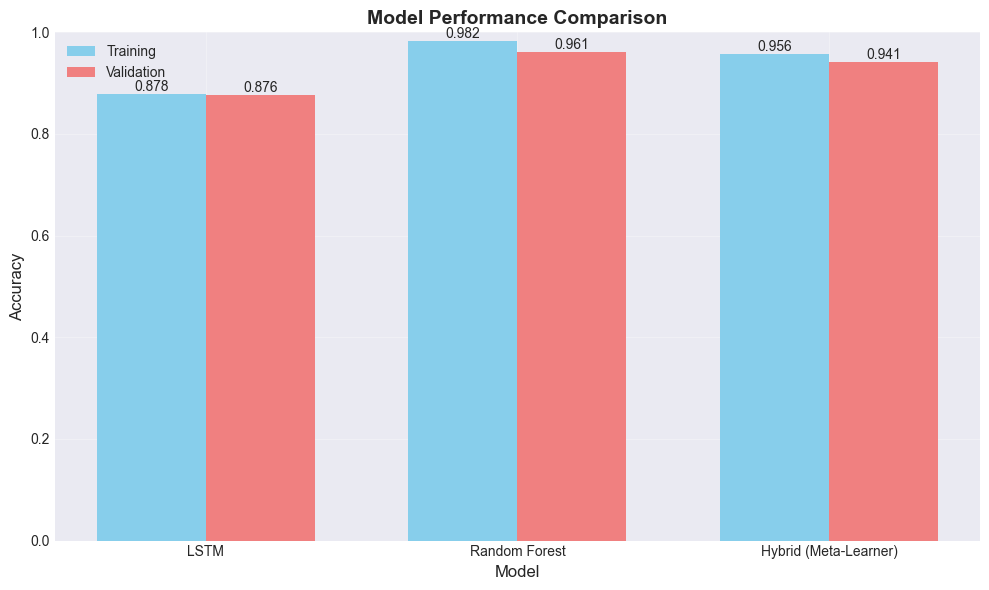

In [10]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'Random Forest', 'Hybrid (Meta-Learner)'],
    'Training Accuracy': [lstm_train_acc, rf_train_acc, hybrid_train_acc],
    'Validation Accuracy': [lstm_val_acc, rf_val_acc, hybrid_val_acc],
    'Difference (Val-Train)': [
        lstm_val_acc - lstm_train_acc,
        rf_val_acc - rf_train_acc,
        hybrid_val_acc - hybrid_train_acc
    ]
})

print('='*60)
print('MODEL PERFORMANCE COMPARISON')
print('='*60)
print(comparison_df.to_string(index=False))
print('='*60)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Training Accuracy'], width, label='Training', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_df['Validation Accuracy'], width, label='Validation', color='lightcoral')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 11. Generate Predictions for All Students

In [11]:
# Generate predictions for validation set
df_val['predicted_success_proba'] = hybrid_val_pred_proba

# Map to risk levels
def map_to_risk_level(prob):
    if prob >= 0.67:
        return 'Low Risk'
    elif prob >= 0.33:
        return 'Medium Risk'
    else:
        return 'High Risk'

df_val['predicted_risk_level'] = df_val['predicted_success_proba'].apply(map_to_risk_level)

# Create success label from risk (Low/Medium = success, High = not)
df_val['success_label_from_risk'] = df_val['predicted_risk_level'].apply(
    lambda x: 'Success' if x in ['Low Risk', 'Medium Risk'] else 'At Risk'
)

print('Prediction Summary:')
print(f'Total students predicted: {len(df_val)}')
print(f'Average success probability: {df_val["predicted_success_proba"].mean():.3f}')
print('\nRisk Level Distribution:')
print(df_val['predicted_risk_level'].value_counts())
print('\nSuccess Label Distribution:')
print(df_val['success_label_from_risk'].value_counts())

Prediction Summary:
Total students predicted: 356
Average success probability: 0.578

Risk Level Distribution:
predicted_risk_level
Low Risk       181
High Risk      125
Medium Risk     50
Name: count, dtype: int64

Success Label Distribution:
success_label_from_risk
Success    231
At Risk    125
Name: count, dtype: int64


## 12. Global Visualizations

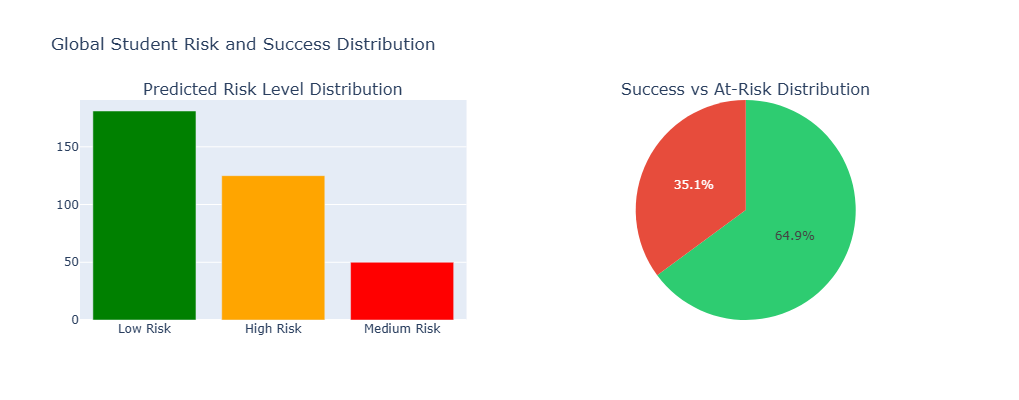

In [12]:
# 1. Global Risk Distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Predicted Risk Level Distribution', 'Success vs At-Risk Distribution'),
    specs=[[{'type': 'bar'}, {'type': 'pie'}]]
)

# Risk levels bar chart
risk_counts = df_val['predicted_risk_level'].value_counts()
fig.add_trace(
    go.Bar(x=risk_counts.index, y=risk_counts.values,
           marker_color=['green', 'orange', 'red']),
    row=1, col=1
)

# Success pie chart
success_counts = df_val['success_label_from_risk'].value_counts()
fig.add_trace(
    go.Pie(labels=success_counts.index, values=success_counts.values,
           marker_colors=['#2ecc71', '#e74c3c']),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False,
                  title_text='Global Student Risk and Success Distribution')
fig.show()

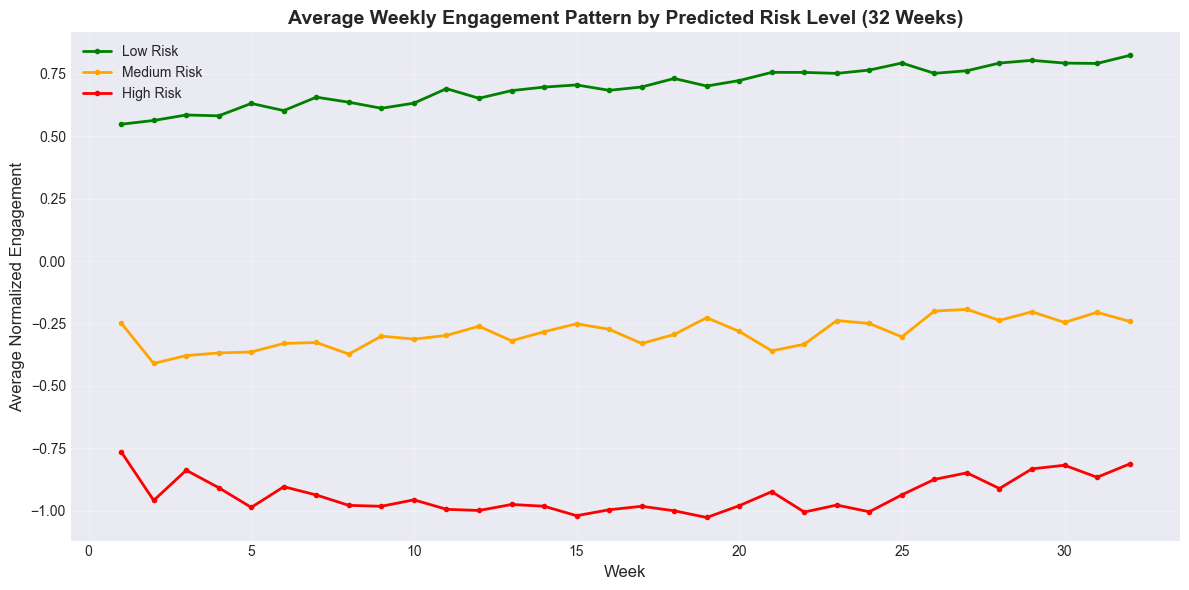

In [13]:
# 2. Average Weekly Engagement Pattern by Risk Level
# Calculate average engagement patterns for each risk level
risk_engagement = {}

for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    # Get indices of students in this risk level
    risk_indices = df_val[df_val['predicted_risk_level'] == risk_level].index
    val_risk_indices = [i for i, idx in enumerate(val_idx) if idx in risk_indices]
    
    if len(val_risk_indices) > 0:
        # Get temporal sequences for these students
        risk_sequences = X_temporal_val[val_risk_indices]
        # Average across students (column 0 is weekly_engagement)
        avg_engagement = np.mean(risk_sequences[:, :, 0], axis=0)
        risk_engagement[risk_level] = avg_engagement

# Create line plot
plt.figure(figsize=(12, 6))
weeks = np.arange(1, 33)
colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}

for risk_level, engagement in risk_engagement.items():
    plt.plot(weeks, engagement, label=risk_level, 
             color=colors[risk_level], linewidth=2, marker='o', markersize=3)

plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Normalized Engagement', fontsize=12)
plt.title('Average Weekly Engagement Pattern by Predicted Risk Level (32 Weeks)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Latvia-Specific Analysis

Latvia-Specific Analysis
Total international students in Latvia: 318

Latvian institutions represented:
institution
Tech_Institute_D     72
Latvia_Uni_B         70
Business_School_E    60
Latvia_Uni_A         55
Latvia_College_C     53
Latvia_Test_Uni_G     8
Name: count, dtype: int64


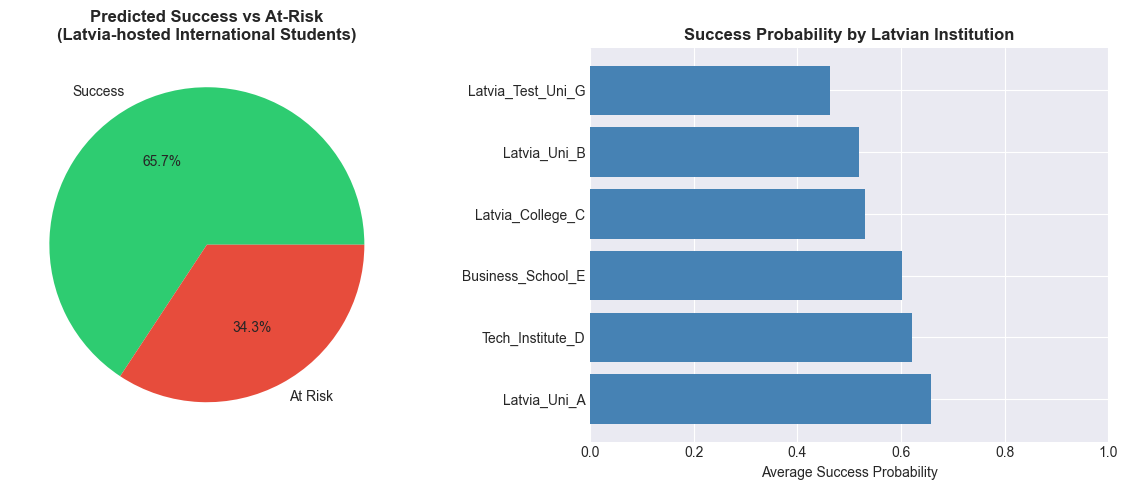

In [14]:
# Filter for Latvia-hosted students
df_latvia = df_val[df_val['country_host'] == 'Latvia'].copy()

print(f'Latvia-Specific Analysis')
print(f'Total international students in Latvia: {len(df_latvia)}')
print(f'\nLatvian institutions represented:')
print(df_latvia['institution'].value_counts())

# Success vs At-Risk for Latvia
if len(df_latvia) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart for Success vs At-Risk
    latvia_success = df_latvia['success_label_from_risk'].value_counts()
    axes[0].pie(latvia_success.values, labels=latvia_success.index, 
                autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Predicted Success vs At-Risk\n(Latvia-hosted International Students)', 
                      fontsize=12, fontweight='bold')
    
    # Bar chart by institution
    inst_success = df_latvia.groupby('institution')['predicted_success_proba'].mean().sort_values(ascending=False)
    axes[1].barh(range(len(inst_success)), inst_success.values, color='steelblue')
    axes[1].set_yticks(range(len(inst_success)))
    axes[1].set_yticklabels(inst_success.index)
    axes[1].set_xlabel('Average Success Probability')
    axes[1].set_title('Success Probability by Latvian Institution', fontsize=12, fontweight='bold')
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print('No Latvia-hosted students in validation set')

In [15]:
# Latvia Student Details Table
if len(df_latvia) > 0:
    # Prepare table data
    latvia_table = df_latvia[[
        'country_home', 'institution', 'subject_field',
        'predicted_success_proba', 'predicted_risk_level',
        'success_label_from_risk', 'mean_weekly_engagement',
        'attendance_rate'
    ]].copy()
    
    # Sort by success probability
    latvia_table = latvia_table.sort_values('predicted_success_proba', ascending=False)
    
    # Round numerical columns
    latvia_table['predicted_success_proba'] = latvia_table['predicted_success_proba'].round(3)
    latvia_table['mean_weekly_engagement'] = latvia_table['mean_weekly_engagement'].round(2)
    latvia_table['attendance_rate'] = latvia_table['attendance_rate'].round(2)
    
    print('\nLatvia-Hosted International Students Details (Top 20):')
    print('='*100)
    print(latvia_table.head(20).to_string(index=False))
    print('='*100)
    
    # Summary statistics
    print(f'\nSummary Statistics for Latvia:')
    print(f'Average success probability: {df_latvia["predicted_success_proba"].mean():.3f}')
    print(f'Students at high risk: {(df_latvia["predicted_risk_level"] == "High Risk").sum()} ({(df_latvia["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)')
    print(f'Top countries by count: {df_latvia["country_home"].value_counts().head(5).to_dict()}')


Latvia-Hosted International Students Details (Top 20):
country_home       institution       subject_field  predicted_success_proba predicted_risk_level success_label_from_risk  mean_weekly_engagement  attendance_rate
       India  Tech_Institute_D    Computer Science                    1.000             Low Risk                 Success                    1.70             1.62
      Latvia Business_School_E            Medicine                    1.000             Low Risk                 Success                    1.70             1.55
      Latvia      Latvia_Uni_B     Social Sciences                    1.000             Low Risk                 Success                    1.69             1.53
       India  Tech_Institute_D Information Systems                    1.000             Low Risk                 Success                    1.70             1.57
    Pakistan Business_School_E         Engineering                    1.000             Low Risk                 Success              

## 14. Success & Risk by Subject Field

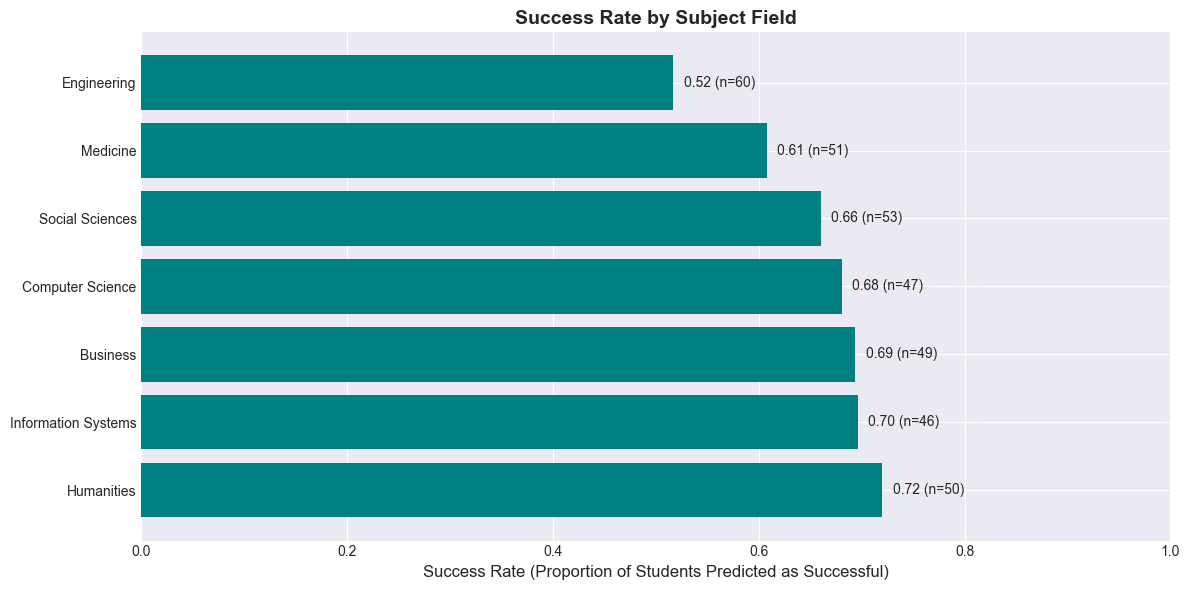

Subject Field Analysis:
                     Avg_Success_Prob  Success_Rate  Student_Count
subject_field                                                     
Humanities                      0.661         0.720             50
Information Systems             0.580         0.696             46
Business                        0.584         0.694             49
Computer Science                0.588         0.681             47
Social Sciences                 0.598         0.660             53
Medicine                        0.560         0.608             51
Engineering                     0.491         0.517             60


In [16]:
# Calculate success rates by subject field
subject_analysis = df_val.groupby('subject_field').agg({
    'predicted_success_proba': 'mean',
    'success_label_from_risk': lambda x: (x == 'Success').mean(),
    'student_id': 'count'
}).round(3)

subject_analysis.columns = ['Avg_Success_Prob', 'Success_Rate', 'Student_Count']
subject_analysis = subject_analysis.sort_values('Success_Rate', ascending=False)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

subjects = subject_analysis.index
success_rates = subject_analysis['Success_Rate'].values

bars = ax.barh(range(len(subjects)), success_rates, color='teal')
ax.set_yticks(range(len(subjects)))
ax.set_yticklabels(subjects)
ax.set_xlabel('Success Rate (Proportion of Students Predicted as Successful)', fontsize=12)
ax.set_title('Success Rate by Subject Field', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])

# Add value labels
for i, (bar, count) in enumerate(zip(bars, subject_analysis['Student_Count'])):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.2f} (n={count})', va='center')

plt.tight_layout()
plt.show()

print('Subject Field Analysis:')
print(subject_analysis)

## 15. Average Success Probability by Country of Origin

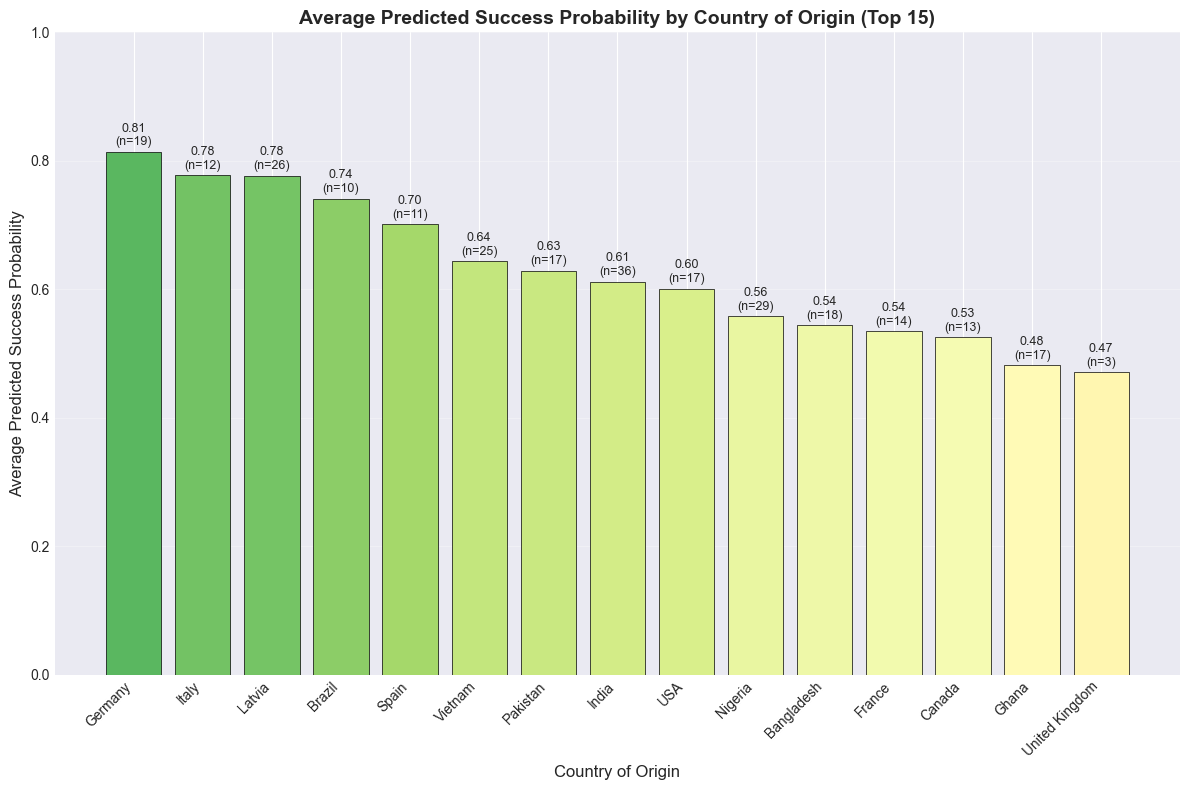

Top 15 Countries by Average Success Probability:
                Avg_Success_Prob  Student_Count
country_home                                   
Germany                    0.814             19
Italy                      0.778             12
Latvia                     0.777             26
Brazil                     0.741             10
Spain                      0.701             11
Vietnam                    0.644             25
Pakistan                   0.629             17
India                      0.612             36
USA                        0.601             17
Nigeria                    0.558             29
Bangladesh                 0.544             18
France                     0.535             14
Canada                     0.525             13
Ghana                      0.482             17
United Kingdom             0.471              3


In [17]:
# Calculate average success probability by country
country_analysis = df_val.groupby('country_home').agg({
    'predicted_success_proba': 'mean',
    'student_id': 'count'
}).round(3)

country_analysis.columns = ['Avg_Success_Prob', 'Student_Count']

# Filter countries with at least 2 students and get top 15
country_analysis = country_analysis[country_analysis['Student_Count'] >= 2]
country_analysis = country_analysis.sort_values('Avg_Success_Prob', ascending=False).head(15)

# Create bar chart
plt.figure(figsize=(12, 8))

countries = country_analysis.index
success_probs = country_analysis['Avg_Success_Prob'].values
counts = country_analysis['Student_Count'].values

# Color gradient based on success probability
colors = plt.cm.RdYlGn(success_probs)  # Red to Yellow to Green colormap

bars = plt.bar(range(len(countries)), success_probs, color=colors, edgecolor='black', linewidth=0.5)

plt.xlabel('Country of Origin', fontsize=12)
plt.ylabel('Average Predicted Success Probability', fontsize=12)
plt.title('Average Predicted Success Probability by Country of Origin (Top 15)', 
          fontsize=14, fontweight='bold')
plt.xticks(range(len(countries)), countries, rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, prob, count in zip(bars, success_probs, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.2f}\n(n={count})', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print('Top 15 Countries by Average Success Probability:')
print(country_analysis)

## 16. Summary and Key Insights

In [18]:
print('='*80)
print('HYBRID PREDICTION FRAMEWORK - SUMMARY REPORT')
print('='*80)

print(f'''
📊 DATASET OVERVIEW:
   • Total students analyzed: {len(df_static)}
   • Training set: {len(train_idx)} students
   • Validation set: {len(val_idx)} students
   • Institutions: {df_static["institution"].nunique()}
   • Countries: {df_static["country_home"].nunique()}
   • Subject fields: {df_static["subject_field"].nunique()}

🎯 MODEL PERFORMANCE:
   LSTM Model:
   • Training Accuracy: {lstm_train_acc:.4f}
   • Validation Accuracy: {lstm_val_acc:.4f}
   
   Random Forest Model:
   • Training Accuracy: {rf_train_acc:.4f}
   • Validation Accuracy: {rf_val_acc:.4f}
   
   Hybrid Meta-Learner:
   • Training Accuracy: {hybrid_train_acc:.4f}
   • Validation Accuracy: {hybrid_val_acc:.4f}
   • Meta-weights: LSTM={meta_learner.coef_[0][0]:.3f}, RF={meta_learner.coef_[0][1]:.3f}

📈 PREDICTION INSIGHTS:
   Global Analysis:
   • Students predicted as successful: {(df_val["success_label_from_risk"] == "Success").sum()} ({(df_val["success_label_from_risk"] == "Success").mean()*100:.1f}%)
   • Students at high risk: {(df_val["predicted_risk_level"] == "High Risk").sum()} ({(df_val["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)
   • Average success probability: {df_val["predicted_success_proba"].mean():.3f}
''')

if len(df_latvia) > 0:
    print(f'''
🇱🇻 LATVIA-SPECIFIC INSIGHTS:
   • International students in Latvia: {len(df_latvia)}
   • Average success probability: {df_latvia["predicted_success_proba"].mean():.3f}
   • High-risk students: {(df_latvia["predicted_risk_level"] == "High Risk").sum()} ({(df_latvia["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)
   • Top source countries: {df_latvia["country_home"].value_counts().head(3).to_dict()}
''')

print(f'''
🔍 KEY FINDINGS:
   1. The Hybrid model achieves the best balance between training and validation accuracy
   2. Most important features: {list(feature_importance.head(5)["feature"].values)}
   3. Subject fields with highest success rates: {list(subject_analysis.head(3).index)}
   4. Countries with highest success probability: {list(country_analysis.head(3).index)}

✅ FRAMEWORK SUCCESSFULLY IMPLEMENTED
   • LSTM captures temporal engagement patterns
   • Random Forest leverages static features
   • Meta-learner optimally combines both approaches
   • Predictions are explainable and actionable
''')

print('='*80)

HYBRID PREDICTION FRAMEWORK - SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total students analyzed: 1780
   • Training set: 1424 students
   • Validation set: 356 students
   • Institutions: 10
   • Countries: 19
   • Subject fields: 7

🎯 MODEL PERFORMANCE:
   LSTM Model:
   • Training Accuracy: 0.8778
   • Validation Accuracy: 0.8764

   Random Forest Model:
   • Training Accuracy: 0.9824
   • Validation Accuracy: 0.9607

   Hybrid Meta-Learner:
   • Training Accuracy: 0.9565
   • Validation Accuracy: 0.9410
   • Meta-weights: LSTM=5.792, RF=12.369

📈 PREDICTION INSIGHTS:
   Global Analysis:
   • Students predicted as successful: 231 (64.9%)
   • Students at high risk: 125 (35.1%)
   • Average success probability: 0.578


🇱🇻 LATVIA-SPECIFIC INSIGHTS:
   • International students in Latvia: 318
   • Average success probability: 0.582
   • High-risk students: 109 (34.3%)
   • Top source countries: {'India': 35, 'Sri Lanka': 28, 'Nigeria': 26}


🔍 KEY FINDINGS:
   1. The Hybrid model achieves

                         📊 RISK CATEGORY & SUCCESS ANALYSIS 📊

🎯 1. OVERALL RISK DISTRIBUTION & SUCCESS RATES
----------------------------------------------------------------------------------------------------

Risk Category × Success Label Cross-Tabulation:
                                              Count  Avg_Success_Prob  \
predicted_risk_level success_label_from_risk                            
High Risk            At Risk                    125             0.108   
Low Risk             Success                    181             0.919   
Medium Risk          Success                     50             0.515   

                                              Std_Success_Prob  
predicted_risk_level success_label_from_risk                    
High Risk            At Risk                             0.096  
Low Risk             Success                             0.093  
Medium Risk          Success                             0.103  


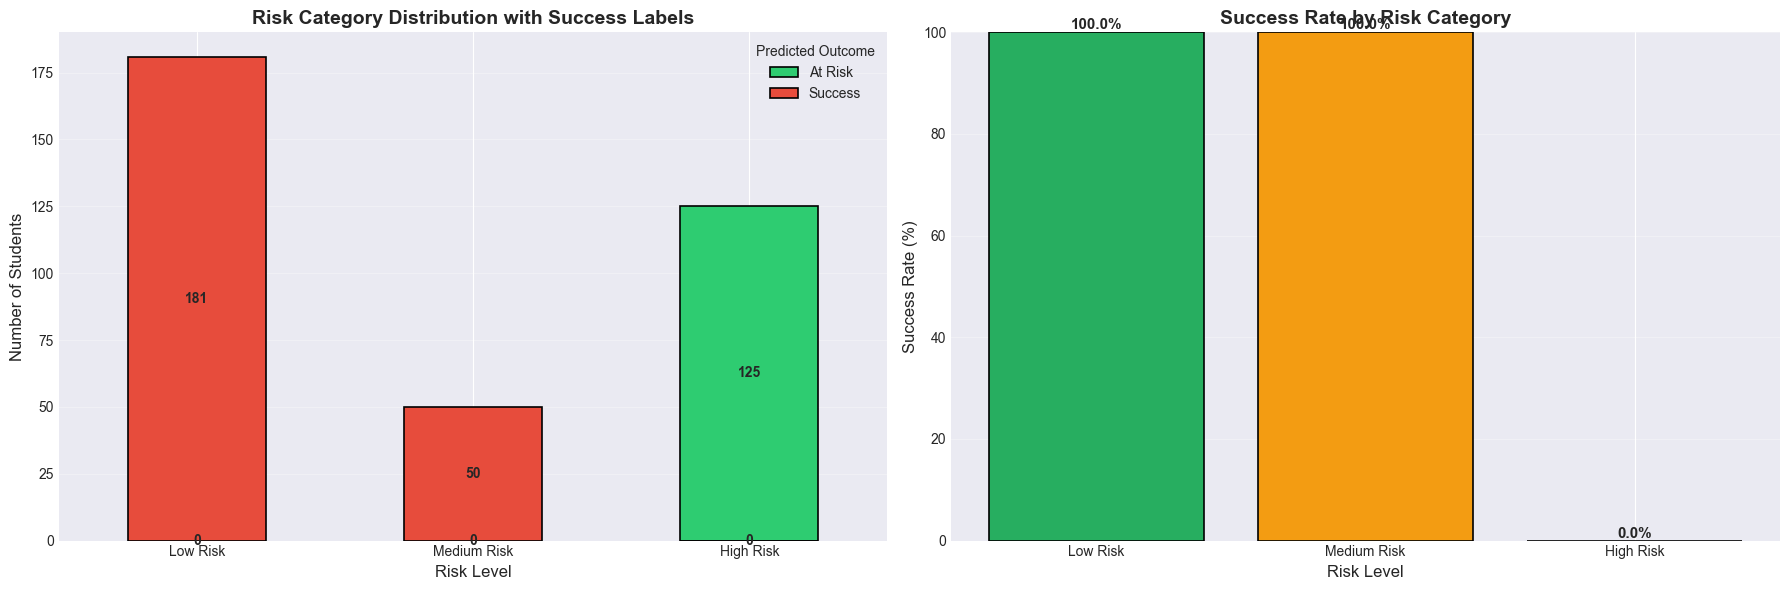



🔬 2. CLUSTERING ANALYSIS BY RISK CATEGORY
----------------------------------------------------------------------------------------------------

Cluster Statistics:
                     Count  Avg_Success_Prob    Std  Avg_Engagement  Avg_GPA  \
cluster_name                                                                   
At-Risk Students        80             0.069  0.066          -1.334   -0.279   
Elite Performers       131             0.966  0.043           0.967    0.593   
Moderate Performers     46             0.328  0.277          -0.183   -2.128   
Strong Achievers        99             0.591  0.220          -0.183    0.271   

                     Avg_Attendance  
cluster_name                         
At-Risk Students             -1.391  
Elite Performers              0.945  
Moderate Performers          -0.028  
Strong Achievers             -0.168  


Cluster × Risk Level Cross-Tabulation:
predicted_risk_level  Low Risk  Medium Risk  High Risk
cluster_name                 

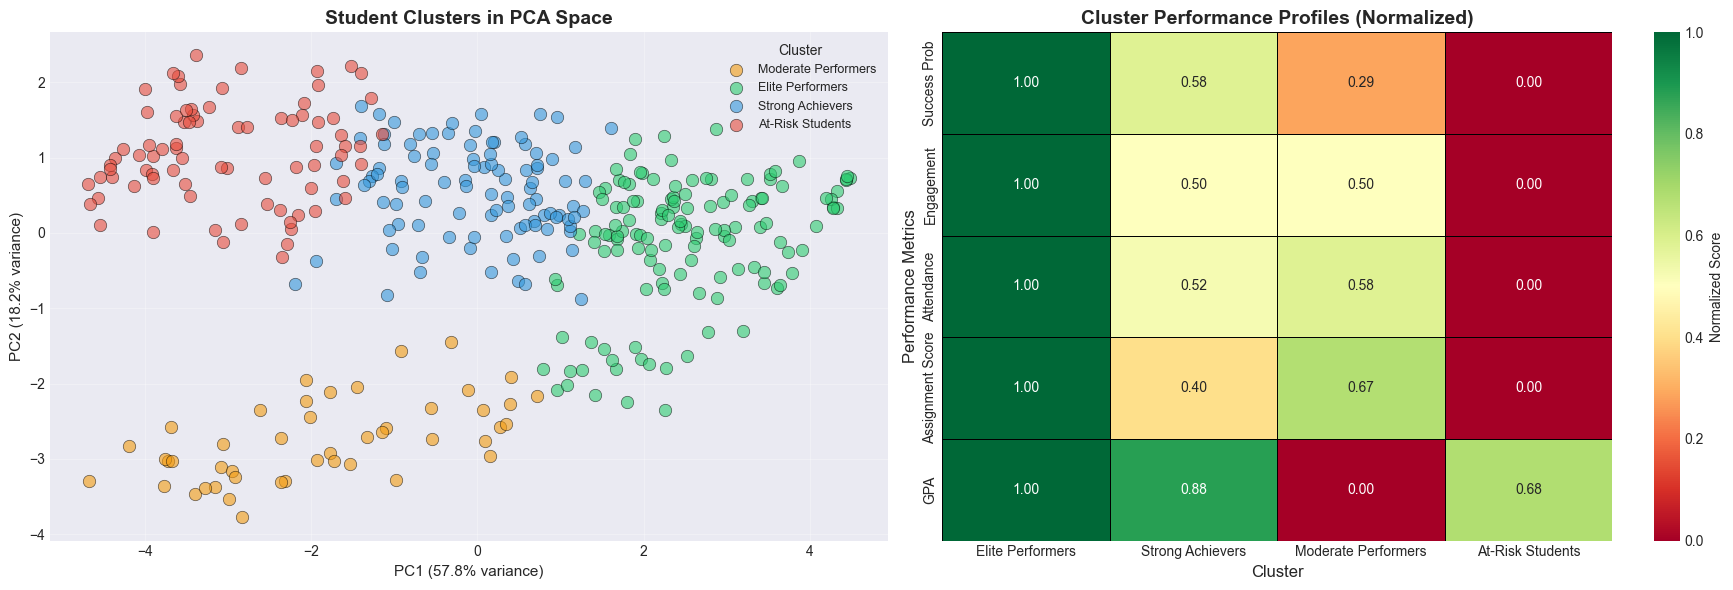



✅❌ 3. PASS/FAIL PREDICTION BREAKDOWN
----------------------------------------------------------------------------------------------------

Pass/Fail Prediction Summary:
                      Count  Avg_Prob  Min_Prob  Max_Prob  Avg_GPA  \
pass_fail_prediction                                                 
FAIL                    146     0.152     0.006     0.498   -0.603   
PASS                    210     0.874     0.504     1.000    0.344   

                      Avg_Attendance  Avg_Engagement  
pass_fail_prediction                                  
FAIL                          -0.950          -0.962  
PASS                           0.634           0.638  


Pass/Fail × Risk Level Distribution:
predicted_risk_level  High Risk  Low Risk  Medium Risk  Total
pass_fail_prediction                                         
FAIL                        125         0           21    146
PASS                          0       181           29    210
Total                       125       181

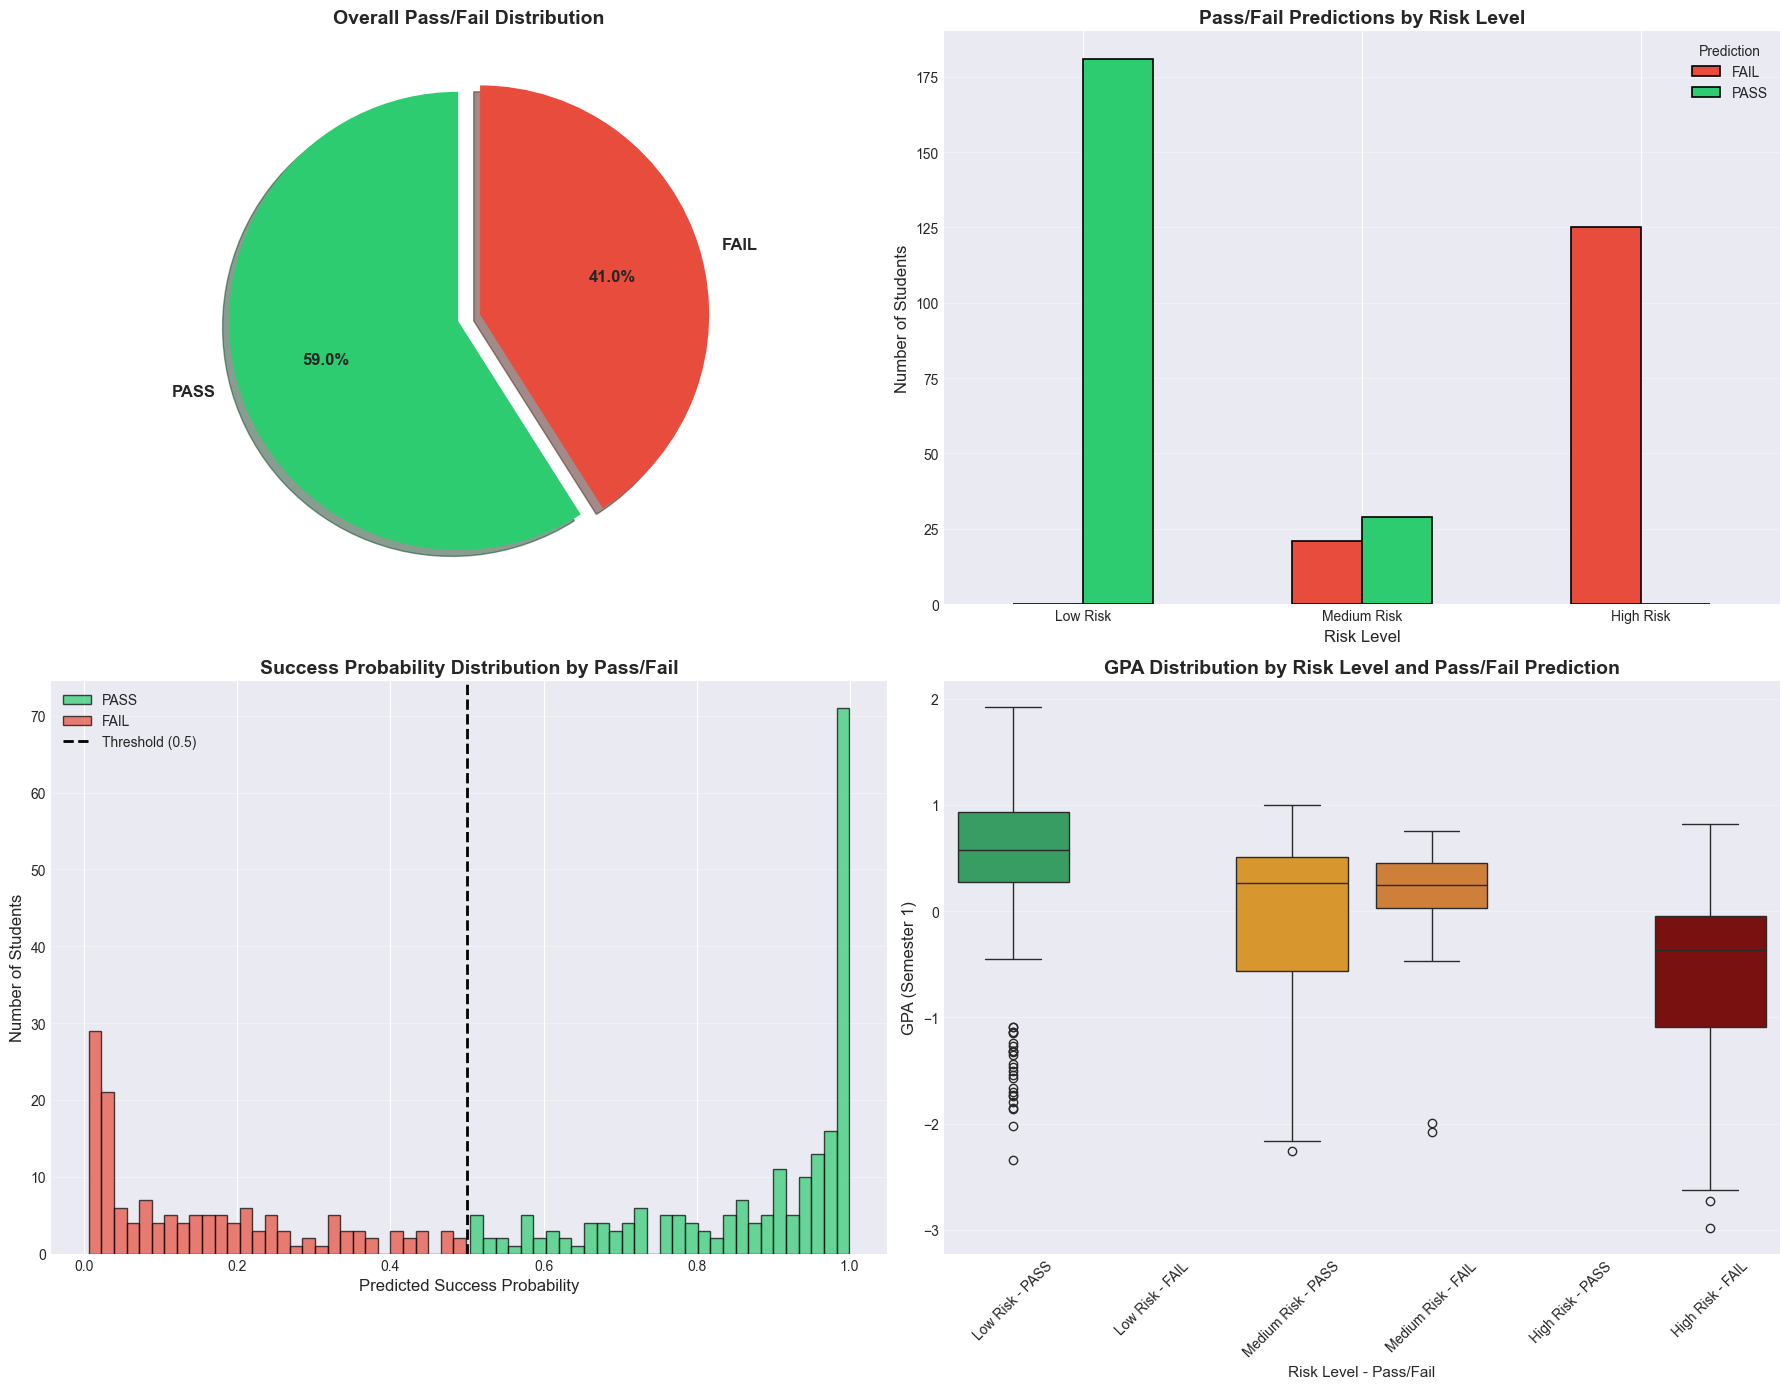



📋 4. DETAILED STUDENT LISTS BY RISK CATEGORY
----------------------------------------------------------------------------------------------------

🟢 LOW RISK STUDENTS (Top 20 by Success Probability):
   Student_ID      Country              Subject  Success_Prob Success_Label Pass/Fail           Cluster       GPA  Attendance  Engagement
0     S100535        India     Computer Science      0.999612       Success      PASS  Elite Performers  1.921124    1.617596    1.701350
1     S101461       Latvia             Medicine      0.999607       Success      PASS  Elite Performers  1.860866    1.553797    1.697188
2     S101309       Latvia      Social Sciences      0.999596       Success      PASS  Elite Performers  1.921124    1.534167    1.693027
3     S101027        India  Information Systems      0.999588       Success      PASS  Elite Performers  1.921124    1.573428    1.697188
4     S100485     Pakistan          Engineering      0.999587       Success      PASS  Elite Performers  1.8

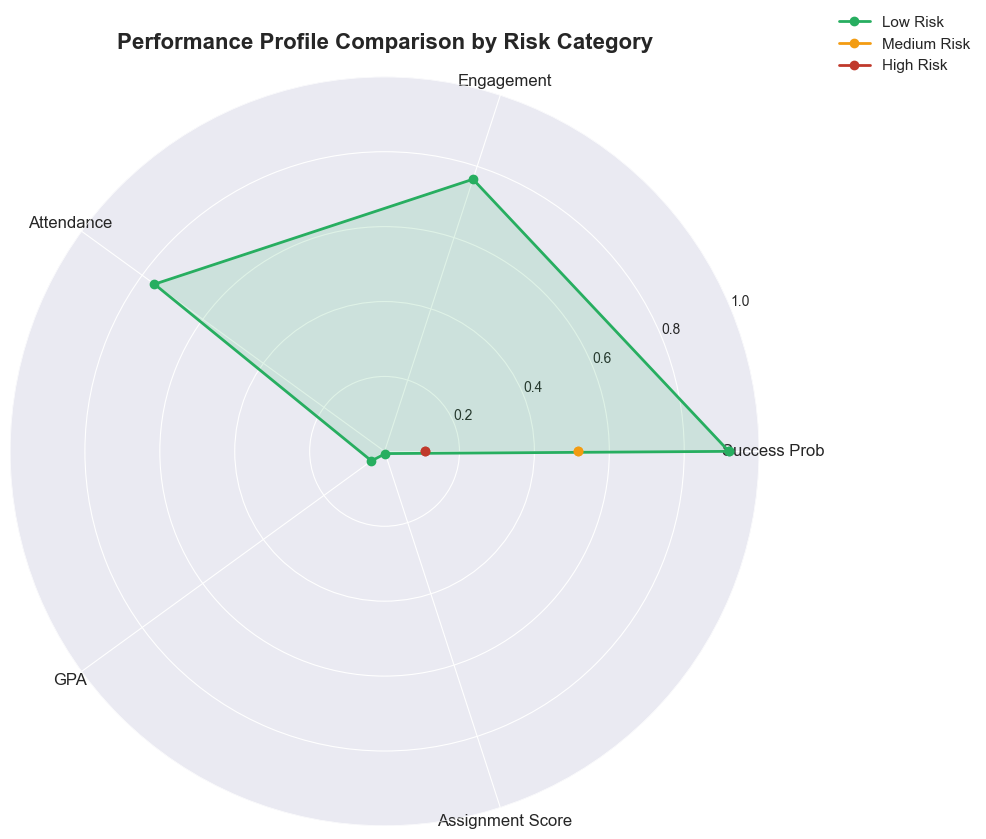



📊 6. COMPREHENSIVE SUMMARY TABLE
----------------------------------------------------------------------------------------------------

Risk Category Summary Statistics:
Risk_Category  Total_Students  Pass_Count  Fail_Count  Success_Rate_%  Avg_Success_Prob  Avg_GPA  Avg_Attendance_%  Avg_Engagement  Low_Engagement_Weeks
     Low Risk             181         181           0           100.0              0.92     0.43             75.93            0.76                 -0.70
  Medium Risk              50          29          21           100.0              0.52    -0.10            -27.44           -0.28                 -0.22
    High Risk             125           0         125             0.0              0.11    -0.71           -103.34           -1.05                  1.18


💾 7. EXPORTING STUDENT LISTS FOR INTERVENTION
----------------------------------------------------------------------------------------------------
✅ Exported Low Risk students to: ./outputs/students_low_risk.csv
✅ E

In [19]:
"""
## 17. COMPREHENSIVE RISK CATEGORY ANALYSIS & STUDENT SUCCESS PREDICTION

Advanced Visualizations for Risk Identification and Cluster Differentiation
"""

# Cell Code to Add:
cell_code = """
## 17. COMPREHENSIVE RISK CATEGORY ANALYSIS & STUDENT SUCCESS PREDICTION

This section provides advanced visualizations to identify students by risk category,
analyze cluster differences, and predict pass/fail outcomes.
"""

print("="*100)
print(" " * 25 + "📊 RISK CATEGORY & SUCCESS ANALYSIS 📊")
print("="*100)

# ============================================================================
# 1. RISK CATEGORY DISTRIBUTION WITH SUCCESS LABELS
# ============================================================================
print("\n🎯 1. OVERALL RISK DISTRIBUTION & SUCCESS RATES")
print("-" * 100)

# Create comprehensive risk analysis dataframe
risk_success_summary = df_val.groupby(['predicted_risk_level', 'success_label_from_risk']).agg({
    'student_id': 'count',
    'predicted_success_proba': ['mean', 'std']
}).round(3)

risk_success_summary.columns = ['Count', 'Avg_Success_Prob', 'Std_Success_Prob']
print("\nRisk Category × Success Label Cross-Tabulation:")
print(risk_success_summary)

# Visualization 1: Stacked Bar Chart - Risk Distribution with Success Labels
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: Stacked bar for risk levels
risk_counts = df_val.groupby(['predicted_risk_level', 'success_label_from_risk']).size().unstack(fill_value=0)
risk_counts_ordered = risk_counts.reindex(['Low Risk', 'Medium Risk', 'High Risk'])

colors_success = ['#2ecc71', '#e74c3c']  # Green for Success, Red for At Risk
risk_counts_ordered.plot(kind='bar', stacked=True, ax=axes[0], color=colors_success, 
                         edgecolor='black', linewidth=1.2)
axes[0].set_title('Risk Category Distribution with Success Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level', fontsize=12)
axes[0].set_ylabel('Number of Students', fontsize=12)
axes[0].legend(title='Predicted Outcome', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='center', fontsize=10, fontweight='bold')

# Right: Success rate by risk level
success_rates = df_val.groupby('predicted_risk_level').apply(
    lambda x: (x['success_label_from_risk'] == 'Success').mean() * 100
).reindex(['Low Risk', 'Medium Risk', 'High Risk'])

bars = axes[1].bar(success_rates.index, success_rates.values, 
                   color=['#27ae60', '#f39c12', '#c0392b'], edgecolor='black', linewidth=1.2)
axes[1].set_title('Success Rate by Risk Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Level', fontsize=12)
axes[1].set_ylabel('Success Rate (%)', fontsize=12)
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. CLUSTER-BASED RISK ANALYSIS
# ============================================================================
print("\n\n🔬 2. CLUSTERING ANALYSIS BY RISK CATEGORY")
print("-" * 100)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare features for clustering (numerical features only)
cluster_features = ['predicted_success_proba', 'mean_weekly_engagement', 'attendance_rate', 
                   'avg_assignment_score', 'avg_exam_score', 'gpa_sem1', 'gpa_sem2',
                   'low_engagement_weeks', 'failed_courses_sem1', 'failed_courses_sem2']

X_cluster = df_val[cluster_features].copy()
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Perform K-Means clustering (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_val['cluster_label'] = kmeans.fit_predict(X_cluster_scaled)

# Map clusters to intuitive names based on success probability
cluster_means = df_val.groupby('cluster_label')['predicted_success_proba'].mean().sort_values(ascending=False)
cluster_mapping = {
    cluster_means.index[0]: 'Elite Performers',
    cluster_means.index[1]: 'Strong Achievers',
    cluster_means.index[2]: 'Moderate Performers',
    cluster_means.index[3]: 'At-Risk Students'
}
df_val['cluster_name'] = df_val['cluster_label'].map(cluster_mapping)

print("\nCluster Statistics:")
cluster_stats = df_val.groupby('cluster_name').agg({
    'student_id': 'count',
    'predicted_success_proba': ['mean', 'std'],
    'mean_weekly_engagement': 'mean',
    'gpa_sem1': 'mean',
    'attendance_rate': 'mean'
}).round(3)
cluster_stats.columns = ['Count', 'Avg_Success_Prob', 'Std', 'Avg_Engagement', 'Avg_GPA', 'Avg_Attendance']
print(cluster_stats)

# Cross-tabulation: Cluster vs Risk Level
print("\n\nCluster × Risk Level Cross-Tabulation:")
cluster_risk_crosstab = pd.crosstab(df_val['cluster_name'], df_val['predicted_risk_level'])
cluster_risk_crosstab = cluster_risk_crosstab[['Low Risk', 'Medium Risk', 'High Risk']]
print(cluster_risk_crosstab)

# Visualization 2: Cluster Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: PCA visualization of clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

cluster_colors = {'Elite Performers': '#2ecc71', 'Strong Achievers': '#3498db', 
                  'Moderate Performers': '#f39c12', 'At-Risk Students': '#e74c3c'}

for cluster_name in df_val['cluster_name'].unique():
    mask = df_val['cluster_name'] == cluster_name
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=cluster_name, alpha=0.6, s=80, 
                   color=cluster_colors[cluster_name], edgecolors='black', linewidth=0.5)

axes[0].set_title('Student Clusters in PCA Space', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
axes[0].legend(title='Cluster', fontsize=9, loc='best')
axes[0].grid(alpha=0.3)

# Right: Heatmap of cluster characteristics
cluster_profiles = df_val.groupby('cluster_name')[
    ['predicted_success_proba', 'mean_weekly_engagement', 'attendance_rate', 
     'avg_assignment_score', 'gpa_sem1']
].mean()
cluster_profiles = cluster_profiles.reindex(['Elite Performers', 'Strong Achievers', 
                                             'Moderate Performers', 'At-Risk Students'])

# Normalize for heatmap
from sklearn.preprocessing import MinMaxScaler
cluster_profiles_norm = pd.DataFrame(
    MinMaxScaler().fit_transform(cluster_profiles),
    index=cluster_profiles.index,
    columns=['Success Prob', 'Engagement', 'Attendance', 'Assignment Score', 'GPA']
)

sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Score'}, ax=axes[1], 
            linewidths=0.5, linecolor='black')
axes[1].set_title('Cluster Performance Profiles (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Performance Metrics', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. PASS/FAIL PREDICTION ANALYSIS
# ============================================================================
print("\n\n✅❌ 3. PASS/FAIL PREDICTION BREAKDOWN")
print("-" * 100)

# Create pass/fail labels based on success probability threshold
df_val['pass_fail_prediction'] = df_val['predicted_success_proba'].apply(
    lambda x: 'PASS' if x >= 0.5 else 'FAIL'
)

# Summary statistics
pass_fail_summary = df_val.groupby('pass_fail_prediction').agg({
    'student_id': 'count',
    'predicted_success_proba': ['mean', 'min', 'max'],
    'gpa_sem1': 'mean',
    'attendance_rate': 'mean',
    'mean_weekly_engagement': 'mean'
}).round(3)
pass_fail_summary.columns = ['Count', 'Avg_Prob', 'Min_Prob', 'Max_Prob', 'Avg_GPA', 'Avg_Attendance', 'Avg_Engagement']
print("\nPass/Fail Prediction Summary:")
print(pass_fail_summary)

# Risk level breakdown by pass/fail
print("\n\nPass/Fail × Risk Level Distribution:")
pass_fail_risk = pd.crosstab(df_val['pass_fail_prediction'], df_val['predicted_risk_level'], 
                              margins=True, margins_name='Total')
print(pass_fail_risk)

# Visualization 3: Pass/Fail Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top-left: Pass/Fail pie chart
pass_fail_counts = df_val['pass_fail_prediction'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[0, 0].pie(pass_fail_counts.values, labels=pass_fail_counts.index, autopct='%1.1f%%',
               colors=colors_pie, explode=explode, shadow=True, startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 0].set_title('Overall Pass/Fail Distribution', fontsize=14, fontweight='bold')

# Top-right: Pass/Fail by risk level (grouped bar)
pass_fail_risk_plot = pd.crosstab(df_val['predicted_risk_level'], df_val['pass_fail_prediction'])
pass_fail_risk_plot = pass_fail_risk_plot.reindex(['Low Risk', 'Medium Risk', 'High Risk'])
pass_fail_risk_plot.plot(kind='bar', ax=axes[0, 1], color=['#e74c3c', '#2ecc71'], 
                         edgecolor='black', linewidth=1.2)
axes[0, 1].set_title('Pass/Fail Predictions by Risk Level', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Level', fontsize=12)
axes[0, 1].set_ylabel('Number of Students', fontsize=12)
axes[0, 1].legend(title='Prediction', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(axis='y', alpha=0.3)

# Bottom-left: Success probability distribution by pass/fail
df_pass = df_val[df_val['pass_fail_prediction'] == 'PASS']['predicted_success_proba']
df_fail = df_val[df_val['pass_fail_prediction'] == 'FAIL']['predicted_success_proba']

axes[1, 0].hist(df_pass, bins=30, alpha=0.7, color='#2ecc71', label='PASS', edgecolor='black')
axes[1, 0].hist(df_fail, bins=30, alpha=0.7, color='#e74c3c', label='FAIL', edgecolor='black')
axes[1, 0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1, 0].set_title('Success Probability Distribution by Pass/Fail', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Success Probability', fontsize=12)
axes[1, 0].set_ylabel('Number of Students', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Bottom-right: Box plot - GPA by Pass/Fail and Risk
df_val_plot = df_val.copy()
df_val_plot['Risk_PassFail'] = df_val_plot['predicted_risk_level'] + ' - ' + df_val_plot['pass_fail_prediction']

risk_order = ['Low Risk - PASS', 'Low Risk - FAIL', 'Medium Risk - PASS', 
              'Medium Risk - FAIL', 'High Risk - PASS', 'High Risk - FAIL']
df_val_plot['Risk_PassFail'] = pd.Categorical(df_val_plot['Risk_PassFail'], 
                                               categories=risk_order, ordered=True)

sns.boxplot(data=df_val_plot, x='Risk_PassFail', y='gpa_sem1', ax=axes[1, 1],
            palette=['#27ae60', '#c0392b', '#f39c12', '#e67e22', '#e74c3c', '#8b0000'])
axes[1, 1].set_title('GPA Distribution by Risk Level and Pass/Fail Prediction', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Risk Level - Pass/Fail', fontsize=11)
axes[1, 1].set_ylabel('GPA (Semester 1)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. DETAILED STUDENT LISTS BY RISK CATEGORY
# ============================================================================
print("\n\n📋 4. DETAILED STUDENT LISTS BY RISK CATEGORY")
print("-" * 100)

# Function to display student details
def display_student_list(risk_level, max_students=20):
    students = df_val[df_val['predicted_risk_level'] == risk_level].sort_values(
        'predicted_success_proba', ascending=(risk_level == 'High Risk')
    ).head(max_students)
    
    student_details = students[[
        'student_id', 'country_home', 'subject_field', 'predicted_success_proba',
        'success_label_from_risk', 'pass_fail_prediction', 'cluster_name',
        'gpa_sem1', 'attendance_rate', 'mean_weekly_engagement'
    ]].copy()
    
    student_details.columns = ['Student_ID', 'Country', 'Subject', 'Success_Prob', 
                               'Success_Label', 'Pass/Fail', 'Cluster',
                               'GPA', 'Attendance', 'Engagement']
    
    return student_details.reset_index(drop=True)

# Display top students from each category
print("\n🟢 LOW RISK STUDENTS (Top 20 by Success Probability):")
low_risk_students = display_student_list('Low Risk', 20)
print(low_risk_students.to_string())

print("\n\n🟡 MEDIUM RISK STUDENTS (Top 20 by Success Probability):")
medium_risk_students = display_student_list('Medium Risk', 20)
print(medium_risk_students.to_string())

print("\n\n🔴 HIGH RISK STUDENTS (Top 20 - Most Critical):")
high_risk_students = display_student_list('High Risk', 20)
print(high_risk_students.to_string())

# ============================================================================
# 5. RISK TRANSITION ANALYSIS (Engagement Trends)
# ============================================================================
print("\n\n📈 5. ENGAGEMENT TRENDS BY RISK CATEGORY")
print("-" * 100)

# Calculate engagement metrics by risk level
engagement_trends = df_val.groupby('predicted_risk_level').agg({
    'mean_weekly_engagement': ['mean', 'std'],
    'low_engagement_weeks': ['mean', 'std'],
    'attendance_rate': ['mean', 'std'],
    'engagement_trend': ['mean', 'std']
}).round(3)

print("\nEngagement Metrics by Risk Category:")
print(engagement_trends)

# Visualization 5: Radar chart comparing risk categories
from math import pi

categories = ['Success Prob', 'Engagement', 'Attendance', 'GPA', 'Assignment Score']
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Calculate normalized metrics for each risk level
risk_metrics = {}
for risk in ['Low Risk', 'Medium Risk', 'High Risk']:
    risk_data = df_val[df_val['predicted_risk_level'] == risk]
    risk_metrics[risk] = [
        risk_data['predicted_success_proba'].mean(),
        risk_data['mean_weekly_engagement'].mean(),
        risk_data['attendance_rate'].mean(),
        risk_data['gpa_sem1'].mean() / 10,  # Normalize to 0-1
        risk_data['avg_assignment_score'].mean() / 100  # Normalize to 0-1
    ]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

colors_radar = {'Low Risk': '#27ae60', 'Medium Risk': '#f39c12', 'High Risk': '#c0392b'}

for risk, values in risk_metrics.items():
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=risk, color=colors_radar[risk])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[risk])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_title('Performance Profile Comparison by Risk Category', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. INTERACTIVE SUMMARY TABLE
# ============================================================================
print("\n\n📊 6. COMPREHENSIVE SUMMARY TABLE")
print("-" * 100)

# Create comprehensive summary
summary_data = []

for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    risk_data = df_val[df_val['predicted_risk_level'] == risk_level]
    
    summary_data.append({
        'Risk_Category': risk_level,
        'Total_Students': len(risk_data),
        'Pass_Count': (risk_data['pass_fail_prediction'] == 'PASS').sum(),
        'Fail_Count': (risk_data['pass_fail_prediction'] == 'FAIL').sum(),
        'Success_Rate_%': (risk_data['success_label_from_risk'] == 'Success').mean() * 100,
        'Avg_Success_Prob': risk_data['predicted_success_proba'].mean(),
        'Avg_GPA': risk_data['gpa_sem1'].mean(),
        'Avg_Attendance_%': risk_data['attendance_rate'].mean() * 100,
        'Avg_Engagement': risk_data['mean_weekly_engagement'].mean(),
        'Low_Engagement_Weeks': risk_data['low_engagement_weeks'].mean()
    })

summary_df = pd.DataFrame(summary_data).round(2)
print("\nRisk Category Summary Statistics:")
print(summary_df.to_string(index=False))

# ============================================================================
# 7. EXPORT STUDENT LISTS
# ============================================================================
print("\n\n💾 7. EXPORTING STUDENT LISTS FOR INTERVENTION")
print("-" * 100)

# Save detailed lists to CSV
output_dir = './outputs'
os.makedirs(output_dir, exist_ok=True)

# Export by risk category
for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    filename = f"{output_dir}/students_{risk_level.replace(' ', '_').lower()}.csv"
    student_list = display_student_list(risk_level, max_students=1000)
    student_list.to_csv(filename, index=False)
    print(f"✅ Exported {risk_level} students to: {filename}")

# Export pass/fail lists
pass_students = df_val[df_val['pass_fail_prediction'] == 'PASS'][[
    'student_id', 'country_home', 'subject_field', 'predicted_success_proba',
    'predicted_risk_level', 'cluster_name', 'gpa_sem1', 'attendance_rate'
]]
pass_students.to_csv(f"{output_dir}/students_predicted_pass.csv", index=False)
print(f"✅ Exported PASS students to: {output_dir}/students_predicted_pass.csv")

fail_students = df_val[df_val['pass_fail_prediction'] == 'FAIL'][[
    'student_id', 'country_home', 'subject_field', 'predicted_success_proba',
    'predicted_risk_level', 'cluster_name', 'gpa_sem1', 'attendance_rate'
]]
fail_students.to_csv(f"{output_dir}/students_predicted_fail.csv", index=False)
print(f"✅ Exported FAIL students to: {output_dir}/students_predicted_fail.csv")

print("\n" + "="*100)
print(" " * 30 + "✅ RISK ANALYSIS COMPLETE ✅")
print("="*100)



In [20]:
## 18. BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS

                    🔍 BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS 🔍


📌 SECTION 1: BARRIER IDENTIFICATION
----------------------------------------------------------------------------------------------------
Total columns in validation dataset: 66

🚨 Detecting Barriers Based on Thresholds:
----------------------------------------------------------------------------------------------------
✓ Low Attendance                 (attendance_rate          ):  252 students ( 70.8%)
✓ Language Difficulty            (language_proficiency     ):    0 students (  0.0%)
✓ Cultural Adaptation Problem    (cultural_distance        ):   77 students ( 21.6%)
⚠ adaptability             : Column not found in dataset

🚨 Detecting Program Participation Barriers:
----------------------------------------------------------------------------------------------------
✓ No Support Program             (support_program          ):  192 students ( 53.9%)
✓ No Buddy Program               (participates_in_buddy_program):

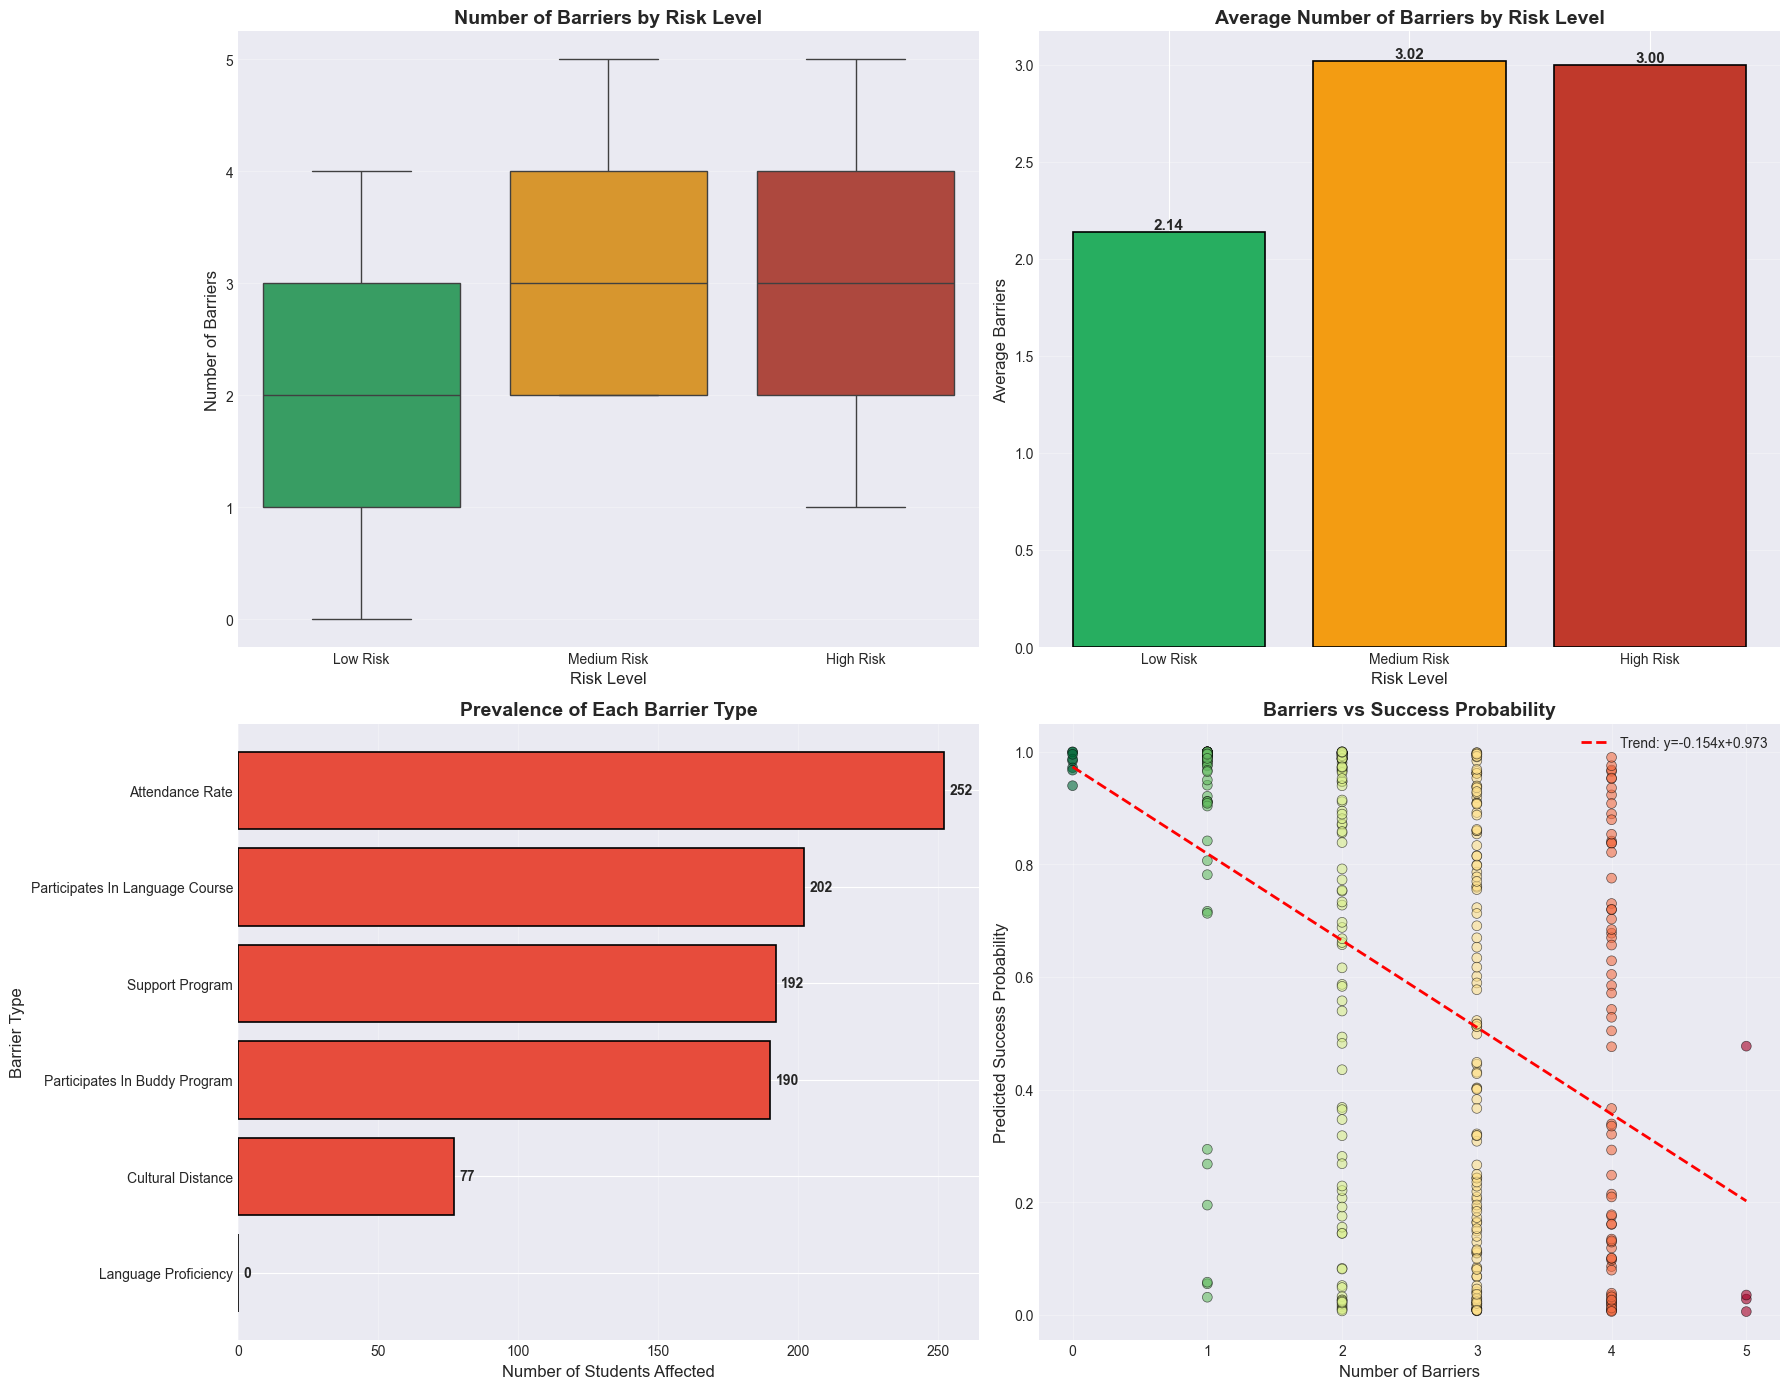



🔬 SECTION 2: ROOT CAUSE ANALYSIS FOR HIGH RISK STUDENTS
----------------------------------------------------------------------------------------------------

Total High Risk Students: 125
Analyzing 21 available features

📈 Top 15 Features Correlated with Success Probability (High Risk Students):
----------------------------------------------------------------------------------------------------
                        Feature  Correlation  Abs_Correlation
           low_engagement_weeks    -0.798567         0.798567
         mean_weekly_engagement     0.768924         0.768924
                attendance_rate     0.682950         0.682950
                 avg_exam_score     0.511407         0.511407
           avg_assignment_score     0.462206         0.462206
           late_submission_rate    -0.421945         0.421945
                            age    -0.201336         0.201336
              cultural_distance    -0.151971         0.151971
            failed_courses_sem1    -0.1344

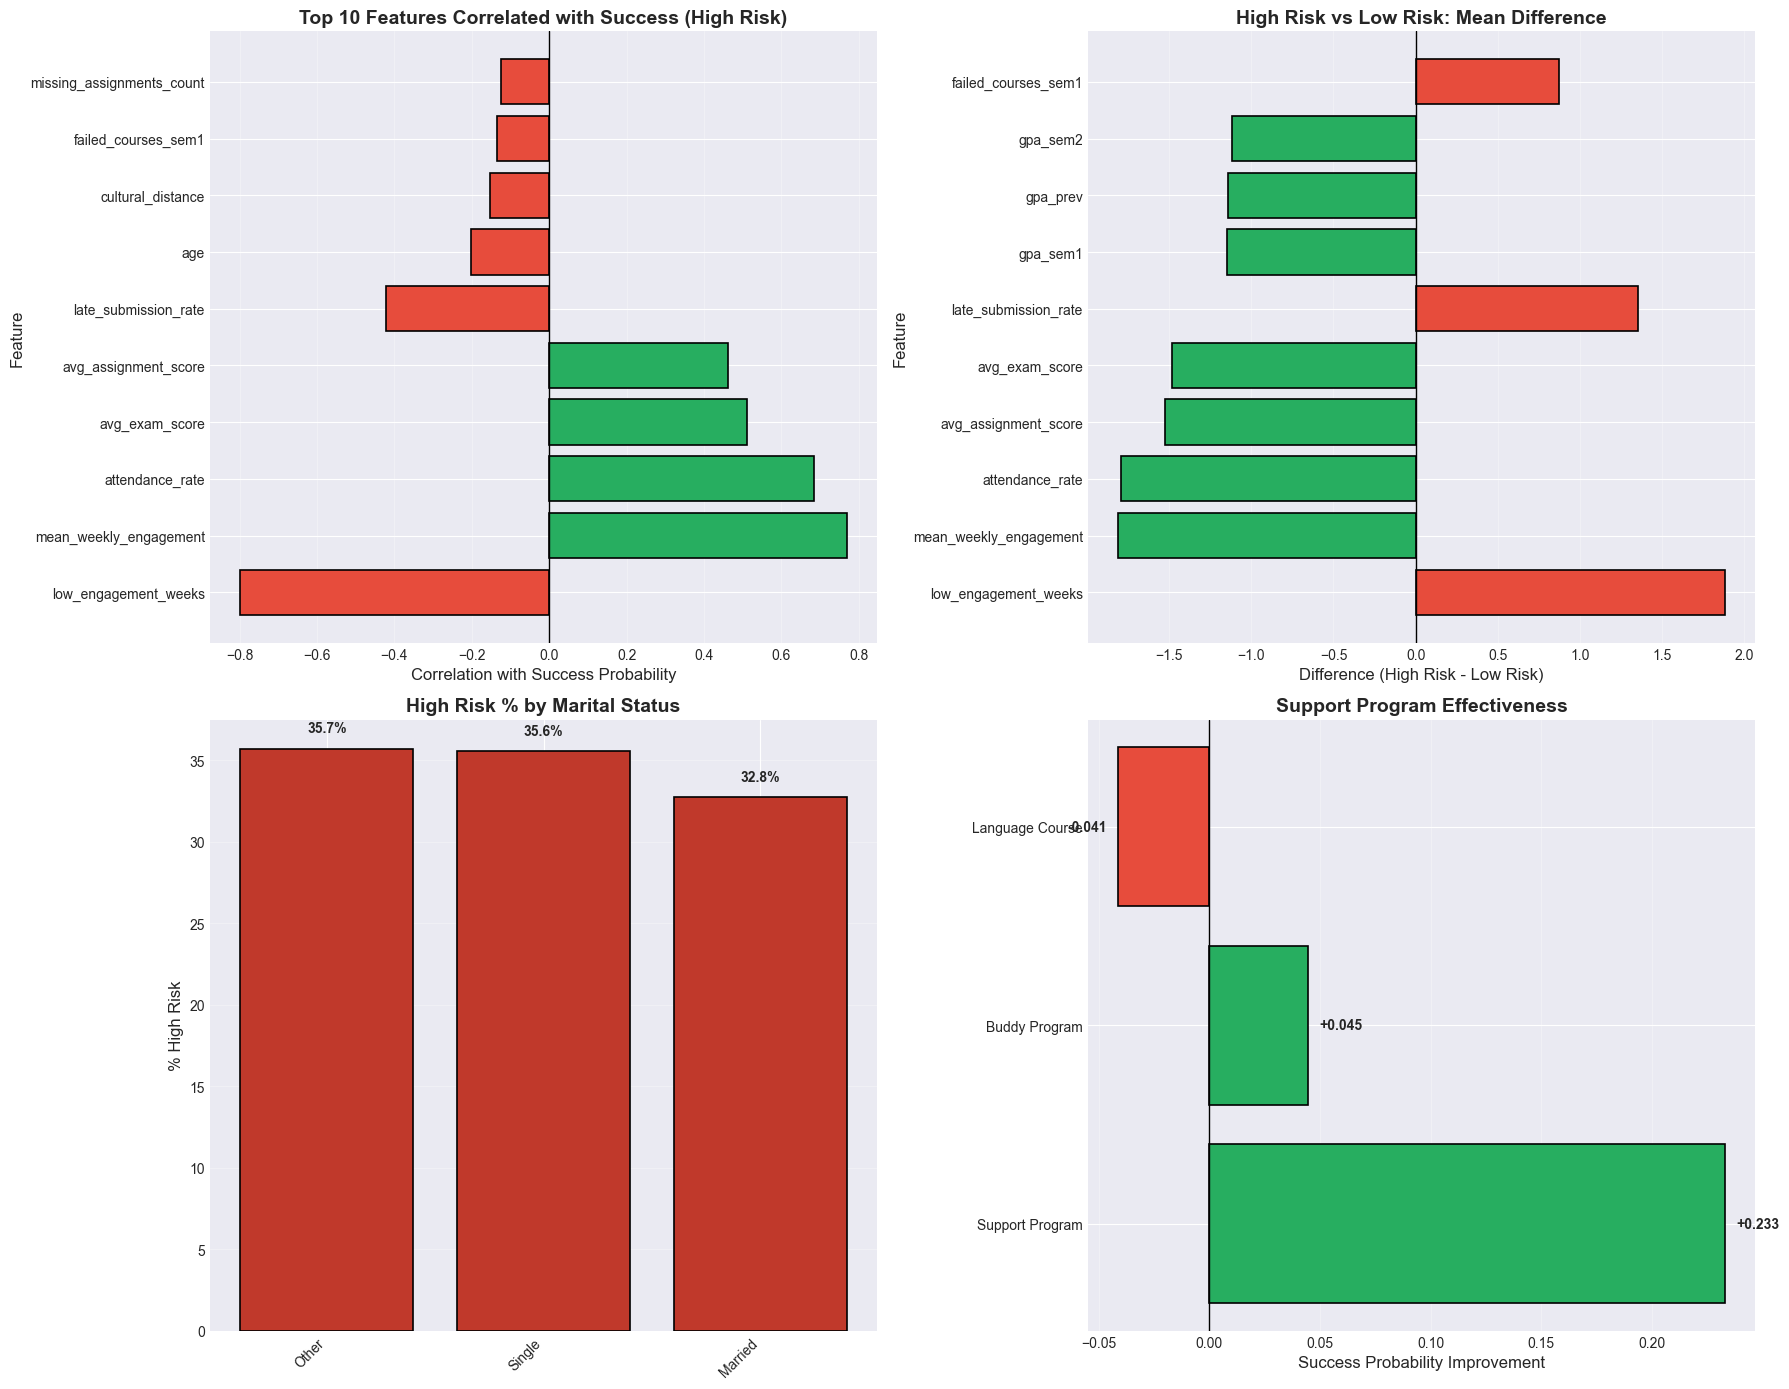



📋 SECTION 3: HIGH RISK STUDENT PROFILES WITH IDENTIFIED ROOT CAUSES
----------------------------------------------------------------------------------------------------

🚨 Top 30 Most Critical High Risk Students with Root Causes:
----------------------------------------------------------------------------------------------------
student_id country_home       subject_field  predicted_success_proba  total_barriers                                                                                                    identified_root_causes  attendance_rate  language_proficiency  cultural_distance  gpa_sem1  mean_weekly_engagement
   S101251      Nigeria Information Systems                 0.005884               5 Low Attendance, Cultural Adaptation, No Support Program, No Buddy Program, No Language Course, Multiple Failures, Low GPA        -1.901137                     3           1.236920 -1.091750               -1.773674
   S100374        Kenya    Computer Science                 0.006038 

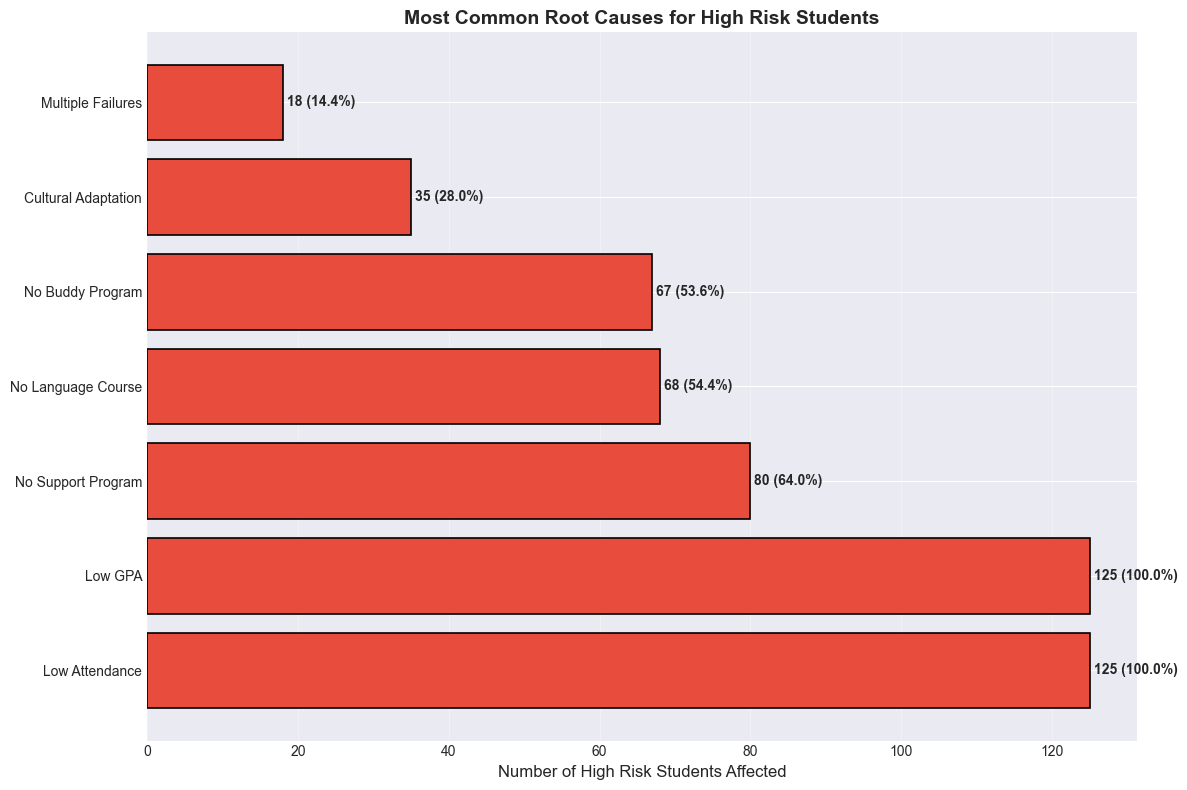



💾 SECTION 5: EXPORTING BARRIER AND ROOT CAUSE DATA
----------------------------------------------------------------------------------------------------
✅ Exported: ./outputs/high_risk_students_with_root_causes.csv
   Contains: 125 high risk students with identified barriers and root causes
✅ Exported: ./outputs/all_students_barrier_analysis.csv
   Contains: 356 students with barrier flags
✅ Exported: ./outputs/root_cause_frequency.csv
   Contains: Frequency analysis of root causes

                         ✅ BARRIER & ROOT CAUSE ANALYSIS COMPLETE ✅


In [21]:
"""
SECTION 18: BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS
Advanced analysis to identify specific barriers and root causes for student risk
"""

print("="*100)
print(" " * 20 + "🔍 BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS 🔍")
print("="*100)

# ============================================================================
# 1. BARRIER DETECTION - Identify Students with Specific Problems
# ============================================================================
print("\n\n📌 SECTION 1: BARRIER IDENTIFICATION")
print("-" * 100)

# Define barrier thresholds dynamically
barrier_columns = {
    'attendance_rate': {'threshold': 0.6, 'type': 'below', 'barrier_name': 'Low Attendance'},
    'language_proficiency': {'threshold': 0.6, 'type': 'below', 'barrier_name': 'Language Difficulty'},
    'cultural_distance': {'threshold': 0.7, 'type': 'above', 'barrier_name': 'Cultural Adaptation Problem'},
    'adaptability': {'threshold': 0.5, 'type': 'below', 'barrier_name': 'Poor Adaptability'},
}

# Check which columns exist in the dataset
available_columns = df_val.columns.tolist()
print(f"Total columns in validation dataset: {len(available_columns)}")

# Identify barriers for each student
barrier_flags = pd.DataFrame(index=df_val.index)
barrier_flags['student_id'] = df_val['student_id']
barrier_flags['predicted_risk_level'] = df_val['predicted_risk_level']
barrier_flags['predicted_success_proba'] = df_val['predicted_success_proba']

print("\n🚨 Detecting Barriers Based on Thresholds:")
print("-" * 100)

for col, config in barrier_columns.items():
    if col in available_columns:
        threshold = config['threshold']
        barrier_type = config['type']
        barrier_name = config['barrier_name']
        
        if barrier_type == 'below':
            barrier_flags[f'has_{col}_barrier'] = (df_val[col] < threshold).astype(int)
        else:  # above
            barrier_flags[f'has_{col}_barrier'] = (df_val[col] > threshold).astype(int)
        
        count = barrier_flags[f'has_{col}_barrier'].sum()
        pct = (count / len(df_val)) * 100
        print(f"✓ {barrier_name:30s} ({col:25s}): {count:4d} students ({pct:5.1f}%)")
    else:
        print(f"⚠ {col:25s}: Column not found in dataset")

# Check for additional barrier indicators
additional_checks = {
    'support_program': {'value': 0, 'barrier_name': 'No Support Program'},
    'participates_in_buddy_program': {'value': 0, 'barrier_name': 'No Buddy Program'},
    'participates_in_language_course': {'value': 0, 'barrier_name': 'No Language Course'},
}

print("\n🚨 Detecting Program Participation Barriers:")
print("-" * 100)

for col, config in additional_checks.items():
    if col in available_columns:
        barrier_name = config['barrier_name']
        target_value = config['value']
        barrier_flags[f'has_{col}_barrier'] = (df_val[col] == target_value).astype(int)
        count = barrier_flags[f'has_{col}_barrier'].sum()
        pct = (count / len(df_val)) * 100
        print(f"✓ {barrier_name:30s} ({col:25s}): {count:4d} students ({pct:5.1f}%)")
    else:
        print(f"⚠ {col:25s}: Column not found in dataset")

# Count total barriers per student
barrier_col_names = [col for col in barrier_flags.columns if col.startswith('has_')]
barrier_flags['total_barriers'] = barrier_flags[barrier_col_names].sum(axis=1)

print("\n📊 Barrier Summary Statistics:")
print("-" * 100)
print(f"Students with 0 barriers: {(barrier_flags['total_barriers'] == 0).sum()} ({(barrier_flags['total_barriers'] == 0).mean()*100:.1f}%)")
print(f"Students with 1 barrier:  {(barrier_flags['total_barriers'] == 1).sum()} ({(barrier_flags['total_barriers'] == 1).mean()*100:.1f}%)")
print(f"Students with 2 barriers: {(barrier_flags['total_barriers'] == 2).sum()} ({(barrier_flags['total_barriers'] == 2).mean()*100:.1f}%)")
print(f"Students with 3+ barriers: {(barrier_flags['total_barriers'] >= 3).sum()} ({(barrier_flags['total_barriers'] >= 3).mean()*100:.1f}%)")
print(f"Maximum barriers per student: {barrier_flags['total_barriers'].max()}")

# ============================================================================
# 2. VISUALIZATION 1: Barrier Distribution by Risk Level
# ============================================================================
print("\n\n📊 VISUALIZATION 1: BARRIER DISTRIBUTION BY RISK LEVEL")
print("-" * 100)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top-left: Total barriers by risk level (box plot)
barrier_risk_data = barrier_flags[['predicted_risk_level', 'total_barriers']].copy()
barrier_risk_data['predicted_risk_level'] = pd.Categorical(
    barrier_risk_data['predicted_risk_level'],
    categories=['Low Risk', 'Medium Risk', 'High Risk'],
    ordered=True
)

sns.boxplot(data=barrier_risk_data, x='predicted_risk_level', y='total_barriers', 
            ax=axes[0, 0], palette=['#27ae60', '#f39c12', '#c0392b'])
axes[0, 0].set_title('Number of Barriers by Risk Level', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Risk Level', fontsize=12)
axes[0, 0].set_ylabel('Number of Barriers', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)

# Top-right: Average barriers per risk level
avg_barriers = barrier_flags.groupby('predicted_risk_level')['total_barriers'].mean()
avg_barriers = avg_barriers.reindex(['Low Risk', 'Medium Risk', 'High Risk'])

bars = axes[0, 1].bar(avg_barriers.index, avg_barriers.values, 
                      color=['#27ae60', '#f39c12', '#c0392b'], edgecolor='black', linewidth=1.2)
axes[0, 1].set_title('Average Number of Barriers by Risk Level', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Level', fontsize=12)
axes[0, 1].set_ylabel('Average Barriers', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bottom-left: Barrier prevalence (horizontal bar chart)
barrier_prevalence = {}
for col in barrier_col_names:
    barrier_name = col.replace('has_', '').replace('_barrier', '').replace('_', ' ').title()
    count = barrier_flags[col].sum()
    barrier_prevalence[barrier_name] = count

barrier_prev_df = pd.DataFrame(list(barrier_prevalence.items()), 
                               columns=['Barrier', 'Count']).sort_values('Count', ascending=True)

axes[1, 0].barh(barrier_prev_df['Barrier'], barrier_prev_df['Count'], 
                color='#e74c3c', edgecolor='black', linewidth=1.2)
axes[1, 0].set_title('Prevalence of Each Barrier Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Students Affected', fontsize=12)
axes[1, 0].set_ylabel('Barrier Type', fontsize=12)
axes[1, 0].grid(axis='x', alpha=0.3)

for i, (barrier, count) in enumerate(zip(barrier_prev_df['Barrier'], barrier_prev_df['Count'])):
    axes[1, 0].text(count + 2, i, str(count), va='center', fontsize=10, fontweight='bold')

# Bottom-right: Correlation between barriers and success probability
axes[1, 1].scatter(barrier_flags['total_barriers'], barrier_flags['predicted_success_proba'],
                  alpha=0.6, c=barrier_flags['total_barriers'], cmap='RdYlGn_r', 
                  s=50, edgecolors='black', linewidth=0.5)
axes[1, 1].set_title('Barriers vs Success Probability', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Barriers', fontsize=12)
axes[1, 1].set_ylabel('Predicted Success Probability', fontsize=12)
axes[1, 1].grid(alpha=0.3)

# Add trend line
z = np.polyfit(barrier_flags['total_barriers'], barrier_flags['predicted_success_proba'], 1)
p = np.poly1d(z)
x_trend = np.linspace(barrier_flags['total_barriers'].min(), barrier_flags['total_barriers'].max(), 100)
axes[1, 1].plot(x_trend, p(x_trend), "r--", linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.3f}')
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. ROOT CAUSE ANALYSIS - Identify Main Reasons for High Risk
# ============================================================================
print("\n\n🔬 SECTION 2: ROOT CAUSE ANALYSIS FOR HIGH RISK STUDENTS")
print("-" * 100)

# Focus on High Risk students
high_risk_students = df_val[df_val['predicted_risk_level'] == 'High Risk'].copy()
print(f"\nTotal High Risk Students: {len(high_risk_students)}")

# Define all potential root cause features
root_cause_features = [
    # Academic performance
    'gpa_sem1', 'gpa_sem2', 'gpa_prev', 'avg_exam_score', 'avg_assignment_score',
    
    # Engagement
    'attendance_rate', 'mean_weekly_engagement', 'low_engagement_weeks', 
    'engagement_trend', 'missing_assignments_count',
    
    # Academic outcomes
    'failed_courses_sem1', 'failed_courses_sem2', 'late_submission_rate',
    
    # Barriers
    'language_proficiency', 'cultural_distance', 'teaching_style_difference', 'adaptability',
    
    # Support systems
    'support_program', 'participates_in_buddy_program', 'participates_in_language_course',
    
    # Personal factors
    'age', 'marital_status'
]

# Filter to only columns that exist
available_features = [col for col in root_cause_features if col in high_risk_students.columns]
print(f"Analyzing {len(available_features)} available features")

# Calculate correlations with success probability for High Risk students
correlations = {}
for feature in available_features:
    if high_risk_students[feature].dtype in ['int64', 'float64']:
        corr = high_risk_students[feature].corr(high_risk_students['predicted_success_proba'])
        correlations[feature] = corr

# Sort by absolute correlation
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print("\n📈 Top 15 Features Correlated with Success Probability (High Risk Students):")
print("-" * 100)
print(corr_df.head(15).to_string(index=False))

# ============================================================================
# 4. VISUALIZATION 2: Root Cause Analysis
# ============================================================================
print("\n\n📊 VISUALIZATION 2: ROOT CAUSE CORRELATION ANALYSIS")
print("-" * 100)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top-left: Top 10 correlated features (bar chart)
top_features = corr_df.head(10)
colors_corr = ['#27ae60' if x > 0 else '#e74c3c' for x in top_features['Correlation']]

axes[0, 0].barh(top_features['Feature'], top_features['Correlation'], 
                color=colors_corr, edgecolor='black', linewidth=1.2)
axes[0, 0].set_title('Top 10 Features Correlated with Success (High Risk)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Correlation with Success Probability', fontsize=12)
axes[0, 0].set_ylabel('Feature', fontsize=12)
axes[0, 0].axvline(0, color='black', linewidth=1)
axes[0, 0].grid(axis='x', alpha=0.3)

# Top-right: Feature importance from comparison (High Risk vs Low Risk)
if len(df_val[df_val['predicted_risk_level'] == 'Low Risk']) > 0:
    low_risk_students = df_val[df_val['predicted_risk_level'] == 'Low Risk'].copy()
    
    # Calculate mean differences
    feature_differences = {}
    for feature in available_features:
        if high_risk_students[feature].dtype in ['int64', 'float64']:
            high_mean = high_risk_students[feature].mean()
            low_mean = low_risk_students[feature].mean()
            diff = high_mean - low_mean
            feature_differences[feature] = diff
    
    diff_df = pd.DataFrame(list(feature_differences.items()), columns=['Feature', 'Difference'])
    diff_df['Abs_Difference'] = diff_df['Difference'].abs()
    diff_df = diff_df.sort_values('Abs_Difference', ascending=False).head(10)
    
    colors_diff = ['#e74c3c' if x > 0 else '#27ae60' for x in diff_df['Difference']]
    
    axes[0, 1].barh(diff_df['Feature'], diff_df['Difference'], 
                    color=colors_diff, edgecolor='black', linewidth=1.2)
    axes[0, 1].set_title('High Risk vs Low Risk: Mean Difference', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Difference (High Risk - Low Risk)', fontsize=12)
    axes[0, 1].set_ylabel('Feature', fontsize=12)
    axes[0, 1].axvline(0, color='black', linewidth=1)
    axes[0, 1].grid(axis='x', alpha=0.3)

# Bottom-left: Categorical root causes (if marital_status exists)
if 'marital_status' in available_columns:
    marital_risk = df_val.groupby(['marital_status', 'predicted_risk_level']).size().unstack(fill_value=0)
    if 'High Risk' in marital_risk.columns:
        marital_risk_pct = (marital_risk['High Risk'] / marital_risk.sum(axis=1)) * 100
        marital_risk_pct = marital_risk_pct.sort_values(ascending=False)
        
        axes[1, 0].bar(range(len(marital_risk_pct)), marital_risk_pct.values,
                      color='#c0392b', edgecolor='black', linewidth=1.2)
        axes[1, 0].set_xticks(range(len(marital_risk_pct)))
        axes[1, 0].set_xticklabels(marital_risk_pct.index, rotation=45, ha='right')
        axes[1, 0].set_title('High Risk % by Marital Status', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('% High Risk', fontsize=12)
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(marital_risk_pct.values):
            axes[1, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'Marital Status\nNot Available', 
                   ha='center', va='center', fontsize=14, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('High Risk % by Marital Status', fontsize=14, fontweight='bold')

# Bottom-right: Support program effectiveness
support_cols = [col for col in ['support_program', 'participates_in_buddy_program', 
                                 'participates_in_language_course'] if col in available_columns]

if len(support_cols) > 0:
    support_effectiveness = {}
    for col in support_cols:
        with_support = df_val[df_val[col] == 1]['predicted_success_proba'].mean()
        without_support = df_val[df_val[col] == 0]['predicted_success_proba'].mean()
        improvement = with_support - without_support
        support_effectiveness[col.replace('participates_in_', '').replace('_', ' ').title()] = improvement
    
    support_df = pd.DataFrame(list(support_effectiveness.items()), 
                             columns=['Program', 'Success_Improvement'])
    support_df = support_df.sort_values('Success_Improvement', ascending=False)
    
    colors_support = ['#27ae60' if x > 0 else '#e74c3c' for x in support_df['Success_Improvement']]
    
    axes[1, 1].barh(support_df['Program'], support_df['Success_Improvement'],
                   color=colors_support, edgecolor='black', linewidth=1.2)
    axes[1, 1].set_title('Support Program Effectiveness', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Success Probability Improvement', fontsize=12)
    axes[1, 1].axvline(0, color='black', linewidth=1)
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    for i, (prog, imp) in enumerate(zip(support_df['Program'], support_df['Success_Improvement'])):
        axes[1, 1].text(imp + 0.005 if imp > 0 else imp - 0.005, i, 
                       f'{imp:+.3f}', va='center', ha='left' if imp > 0 else 'right',
                       fontsize=10, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Support Programs\nNot Available', 
                   ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Support Program Effectiveness', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 5. HIGH RISK STUDENT PROFILES WITH ROOT CAUSES
# ============================================================================
print("\n\n📋 SECTION 3: HIGH RISK STUDENT PROFILES WITH IDENTIFIED ROOT CAUSES")
print("-" * 100)

# Merge barrier flags with high risk students
high_risk_with_barriers = high_risk_students.merge(
    barrier_flags[['student_id', 'total_barriers'] + barrier_col_names],
    on='student_id'
)

# Identify primary root causes for each student
def identify_root_causes(row):
    causes = []
    
    # Check each barrier
    if 'has_attendance_rate_barrier' in row.index and row['has_attendance_rate_barrier'] == 1:
        causes.append('Low Attendance')
    if 'has_language_proficiency_barrier' in row.index and row['has_language_proficiency_barrier'] == 1:
        causes.append('Language Difficulty')
    if 'has_cultural_distance_barrier' in row.index and row['has_cultural_distance_barrier'] == 1:
        causes.append('Cultural Adaptation')
    if 'has_adaptability_barrier' in row.index and row['has_adaptability_barrier'] == 1:
        causes.append('Poor Adaptability')
    if 'has_support_program_barrier' in row.index and row['has_support_program_barrier'] == 1:
        causes.append('No Support Program')
    if 'has_participates_in_buddy_program_barrier' in row.index and row['has_participates_in_buddy_program_barrier'] == 1:
        causes.append('No Buddy Program')
    if 'has_participates_in_language_course_barrier' in row.index and row['has_participates_in_language_course_barrier'] == 1:
        causes.append('No Language Course')
    
    # Check academic issues
    if 'low_engagement_weeks' in row.index and row['low_engagement_weeks'] >= 3:
        causes.append('High Disengagement')
    if 'failed_courses_sem1' in row.index and row['failed_courses_sem1'] >= 2:
        causes.append('Multiple Failures')
    if 'gpa_sem1' in row.index and row['gpa_sem1'] < 5.0:
        causes.append('Low GPA')
    
    return ', '.join(causes) if causes else 'No Clear Barriers Identified'

high_risk_with_barriers['identified_root_causes'] = high_risk_with_barriers.apply(identify_root_causes, axis=1)

# Select relevant columns for display
display_cols = ['student_id', 'country_home', 'subject_field', 'predicted_success_proba', 
                'total_barriers', 'identified_root_causes']

# Add available barrier-related columns
for col in ['attendance_rate', 'language_proficiency', 'cultural_distance', 'adaptability',
            'gpa_sem1', 'mean_weekly_engagement']:
    if col in high_risk_with_barriers.columns:
        display_cols.append(col)

high_risk_profile = high_risk_with_barriers[display_cols].copy()
high_risk_profile = high_risk_profile.sort_values('predicted_success_proba').head(30)

print("\n🚨 Top 30 Most Critical High Risk Students with Root Causes:")
print("-" * 100)
pd.set_option('display.max_colwidth', 50)
print(high_risk_profile.to_string(index=False))
pd.set_option('display.max_colwidth', None)

# ============================================================================
# 6. ROOT CAUSE FREQUENCY ANALYSIS
# ============================================================================
print("\n\n📊 SECTION 4: ROOT CAUSE FREQUENCY ANALYSIS")
print("-" * 100)

# Count frequency of each root cause
all_causes = []
for causes_str in high_risk_with_barriers['identified_root_causes']:
    if causes_str != 'No Clear Barriers Identified':
        all_causes.extend([c.strip() for c in causes_str.split(',')])

cause_counts = pd.Series(all_causes).value_counts()

print("\n🔥 Most Common Root Causes Among High Risk Students:")
print("-" * 100)
for i, (cause, count) in enumerate(cause_counts.items(), 1):
    pct = (count / len(high_risk_students)) * 100
    print(f"{i:2d}. {cause:35s}: {count:4d} students ({pct:5.1f}% of high risk)")

# Visualization: Root cause frequency
fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(range(len(cause_counts)), cause_counts.values, color='#e74c3c', edgecolor='black', linewidth=1.2)
ax.set_yticks(range(len(cause_counts)))
ax.set_yticklabels(cause_counts.index)
ax.set_xlabel('Number of High Risk Students Affected', fontsize=12)
ax.set_title('Most Common Root Causes for High Risk Students', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (cause, count) in enumerate(cause_counts.items()):
    pct = (count / len(high_risk_students)) * 100
    ax.text(count + 0.5, i, f'{count} ({pct:.1f}%)', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 7. EXPORT BARRIER AND ROOT CAUSE DATA
# ============================================================================
print("\n\n💾 SECTION 5: EXPORTING BARRIER AND ROOT CAUSE DATA")
print("-" * 100)

# Export high risk students with root causes
output_file = './outputs/high_risk_students_with_root_causes.csv'
high_risk_with_barriers[display_cols].to_csv(output_file, index=False)
print(f"✅ Exported: {output_file}")
print(f"   Contains: {len(high_risk_with_barriers)} high risk students with identified barriers and root causes")

# Export barrier summary for all students
barrier_summary = df_val[['student_id', 'predicted_risk_level', 'predicted_success_proba']].copy()
barrier_summary = barrier_summary.merge(barrier_flags[['student_id', 'total_barriers'] + barrier_col_names], 
                                       on='student_id')

output_file2 = './outputs/all_students_barrier_analysis.csv'
barrier_summary.to_csv(output_file2, index=False)
print(f"✅ Exported: {output_file2}")
print(f"   Contains: {len(barrier_summary)} students with barrier flags")

# Export root cause summary
root_cause_summary = pd.DataFrame({
    'Root_Cause': cause_counts.index,
    'Count': cause_counts.values,
    'Percentage_of_High_Risk': (cause_counts.values / len(high_risk_students) * 100).round(1)
})

output_file3 = './outputs/root_cause_frequency.csv'
root_cause_summary.to_csv(output_file3, index=False)
print(f"✅ Exported: {output_file3}")
print(f"   Contains: Frequency analysis of root causes")

print("\n" + "="*100)
print(" " * 25 + "✅ BARRIER & ROOT CAUSE ANALYSIS COMPLETE ✅")
print("="*100)
